In [1]:
import tarfile
import gzip
import os
import cPickle as pickle
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
import seaborn as sns
from scipy import stats


In [2]:
def extract(fname,filetowrite,g,logger):
    if (fname.endswith("tar.gz")):
        tar = tarfile.open(fname, "r:gz")
        tar.extractall()
        tar.close()
    elif (fname.endswith("tar")):
        tar = tarfile.open(fname, "r:")
        tar.extractall()
        tar.close()
    elif (fname.endswith("gz")):
        Parse(fname,filetowrite,g,logger)
        

In [3]:
def func(files,filetowrite,g,logger):
    for file in files:
        if os.path.isdir(file):
            g=os.path.abspath(file)
            func(os.listdir(g),filetowrite,g,logger)
        else:
            extract(file,filetowrite,g,logger)
 

In [4]:
def Parse(fname,filetowrite,g,logger):
    fname=os.path.join(g,fname)
    f=gzip.open(fname, 'rb')
    #shutil.copyfileobj(f,filetowrite)
#    with open(file, 'r') as f:
    firstline = f.readline().rstrip() 
    identifier=firstline[2:]
    if firstline[5]=='a':
        typeof='alcoholic'
    else:
        typeof='control'
    f.readline()
    f.readline()
    obj=f.readline().split()
    try:
        subject=obj[1]
    except IndexError:
        subject='NotAvailable'
        logger.write("Eror in {0} and {1} " .format(fname,obj))
    while True:
        info=f.readline().split()
        if not info: break
        try:
            channel=info[3]
            logger.write("Eror in {0} and {1} ".format(fname,info))
        except IndexError:
            channel="NotAvailable"
        global outputdump
        #list strcutire['identifier',typeof,subject,channel,trial,sensor position,sample number,sensor value]
    
        for x in xrange(256):
           inputparam=f.readline().rstrip().split()
           try:
               temp=identifier,typeof,subject,channel,inputparam[0],inputparam[1],inputparam[2],inputparam[3]
    #       print temp
               outputdump.append(temp)
           except:
               continue
#    pickle.dump(outputdump,filetowrite)
    #MainProcessing start

        
       

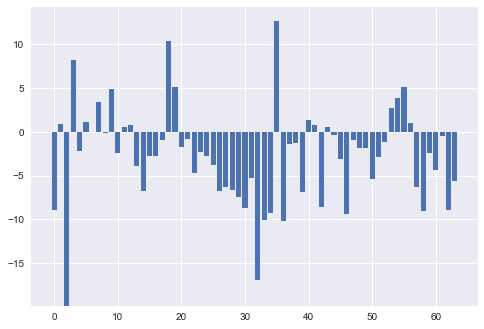

In [36]:
    try:
        databasename='output.dat'
        fil=open(databasename,"rb")
        dataset=pickle.load(fil)
    except:            
        filetowrite=open(databasename,"wb") 
        loggerfile=open('trace.txt',"wb")
        files=os.listdir(os.getcwd())
        func(files,filetowrite,os.getcwd(),loggerfile)
        pickle.dump(outputdump,filetowrite)
        fil=open(databasename,"rb")
        dataset=pickle.load(fil)
    df = pd.DataFrame(data = dataset, columns=['identifier','typeof','subject','channel','trial','sensorPosition','sampleNumber','sensorValue'])
#   ild=df[df['subject']=='S1']
#   print df
#   iff=df.groupby(df['channel']).count()
    ch=df.groupby([df['channel']])['sensorValue'].first()
    ch=ch.reset_index()

    ch=ch.astype(float)
    plt.bar(ch['channel'],ch['sensorValue'])
    sns.plt.show()

    

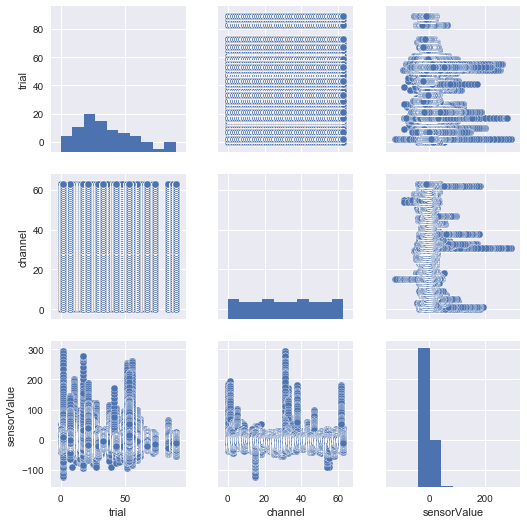

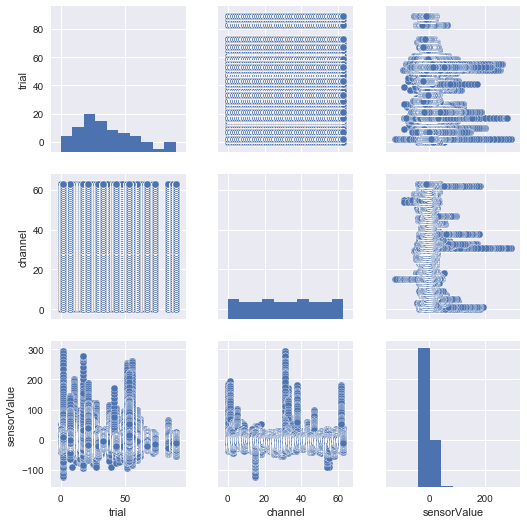

In [8]:
    sp=df[['trial','channel','sensorValue']]
    sp=sp.astype(float)
    sns.pairplot(sp)
    sns.plt.show()

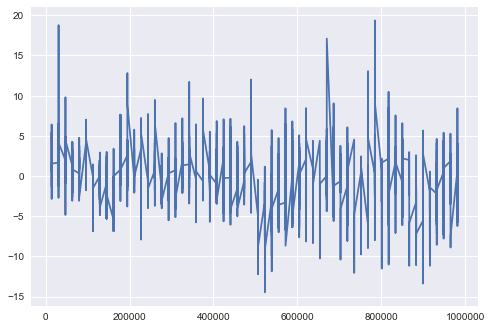

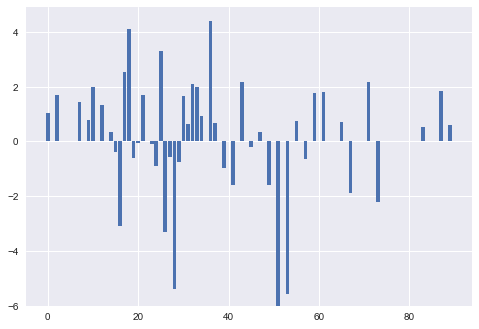

In [9]:
   pt=df[df['channel']=='56']
   pt=pt[['channel','sensorValue']]
   pt=pt.astype(float)
   plt.plot(pt['sensorValue'])
#    plt.plot(ch['channel'])
   sns.plt.show()
   q2=pt=df[df['channel']=='56']
   q2=q2.groupby([df['trial']])['sensorValue'].first()
   q2=q2.reset_index()
#   print q2
   q2=q2.astype(float)
   plt.bar(q2['trial'],q2['sensorValue'])
   plt.show()
   

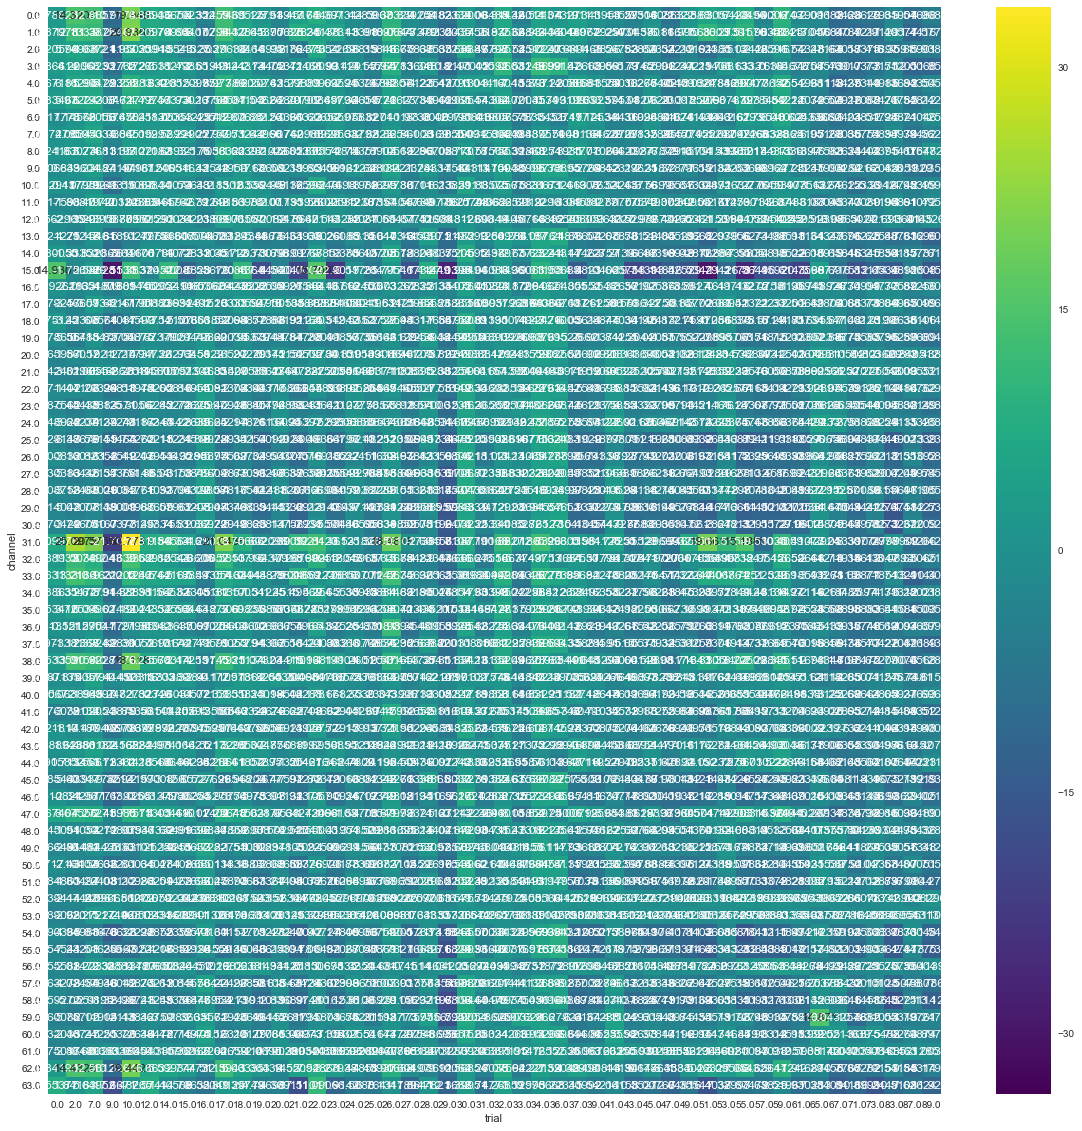

In [20]:
q3=df[['channel','trial','sensorValue']]
# q3[['sensorValue']]=q3[['sensorValue']].resample('3T').mean()
q3=q3.astype(float)
q3=q3.groupby([q3['channel'],q3['trial']])['sensorValue'].mean()
q3=q3.reset_index()
#    print q3
plt.figure(figsize=(20,20))
result = q3.pivot('channel','trial','sensorValue')
sns.heatmap(result, annot=True, fmt="g", cmap='viridis')
plt.show()
# 

In [26]:
"""Here we are computing the cross corelation between the different sensor position for subject S1 for all avaailable trials.
and then we are looking for the sensor positions which have the highest cross-corrleation"""
maxtillnow=-100000000000
electrode1=None
electrode2=None
listedtrials=df[df['subject']=='S1']
listedtrials=listedtrials.groupby([listedtrials['trial']])['sensorValue'].first()
#    print listedtrials
listedtrials=listedtrials.reset_index()
alltrials=listedtrials['trial'].get_values()
for trial in alltrials:
   q4=df[df['trial']==trial]
   q4[['channel','sensorValue']]=q4[['channel','sensorValue']].apply(pd.to_numeric)
   for x in xrange(64):

       input1=q4[q4['channel']==x]
       input11=input1['sensorValue']
       for y in xrange(64):
           if x == y :
               y=y+1
               continue
           input2=q4[q4['channel']==y]
           input12=input2['sensorValue']
           out=np.correlate(input11,input12)
           if out>maxtillnow:
               maxtillnow=out
               electrode1=input1['sensorPosition'].get_values()[0]
               electrode2=input2['sensorPosition'].get_values()[0]
           y=y+1
       x=x+1
   p1=df.groupby(df['sensorPosition']).count()
   p1=p1.reset_index()
   countelectrode1=p1[p1['sensorPosition']==electrode1]
   countelectrode1=countelectrode1['sensorPosition'].get_values()[0]
   countelectrode2=p1[p1['sensorPosition']==electrode2]
   countelectrode2=countelectrode2['sensorPosition'].get_values()[0]
   maxCount=countelectrode1 if countelectrode1>=countelectrode2 else countelectrode2
   print "Max count Sensor Position is ",maxCount
   print "electrodes having the highest correlation are {} and {} for trial {} ".format(electrode1,electrode2,trial)
  # print "and the correlation value is", maxtillnow

Max count Sensor Position is  Y
electrodes having the highest correlation are CZ and Y for trial 0 
Max count Sensor Position is  X
electrodes having the highest correlation are FP1 and X for trial 10 
Max count Sensor Position is  X
electrodes having the highest correlation are FP1 and X for trial 12 
Max count Sensor Position is  X
electrodes having the highest correlation are FP1 and X for trial 14 
Max count Sensor Position is  X
electrodes having the highest correlation are FP1 and X for trial 16 
Max count Sensor Position is  X
electrodes having the highest correlation are FP1 and X for trial 18 
Max count Sensor Position is  X
electrodes having the highest correlation are FP1 and X for trial 2 
Max count Sensor Position is  X
electrodes having the highest correlation are FP1 and X for trial 20 
Max count Sensor Position is  X
electrodes having the highest correlation are FP1 and X for trial 22 
Max count Sensor Position is  X
electrodes having the highest correlation are FP1 and

<p>Here we can see that the electrode having the most correlation in almost all trial is X </p>

         sensorValue
count  327680.000000
mean       -2.889747
std         9.302859
min       -92.539000
25%        -7.111000
50%        -2.563000
75%         0.977000
max       183.777000
         sensorValue
count  327680.000000
mean       -4.442456
std        11.818993
min       -94.655000
25%       -10.010000
50%        -4.415000
75%         0.407000
max       278.687000


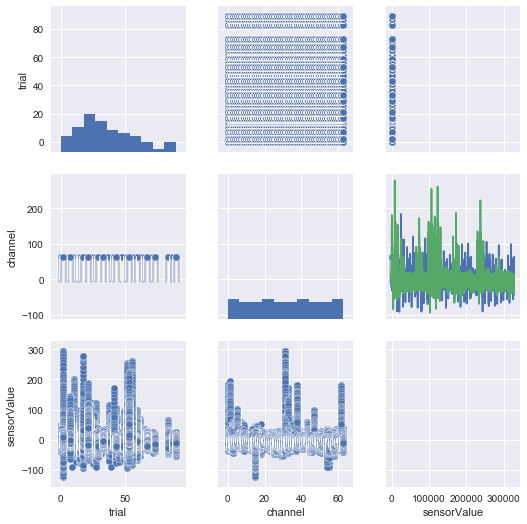

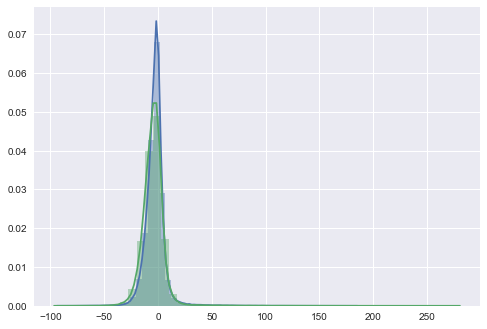

Ttest_relResult(statistic=array([ 60.43492541]), pvalue=array([ 0.]))


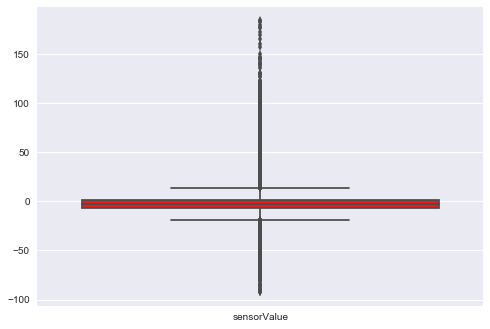

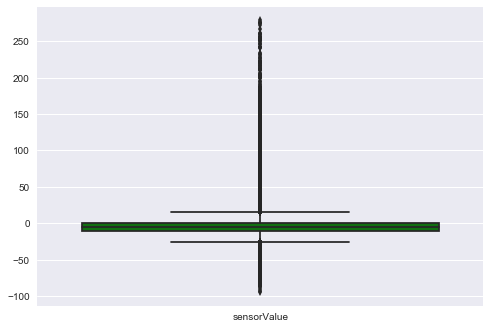

Ttest_1sampResult(statistic=array([-177.81500464]), pvalue=array([ 0.]))
Ttest_indResult(statistic=array([ 59.09329339]), pvalue=array([ 0.]))


In [29]:
# creating two groups
"""Here we are trying to gauge any difference between the alcoholic and control group which are having subject as S2"""
sp=df[['trial','channel','sensorValue']]
sp=sp.astype(float)
sns.pairplot(sp)
listedtrials=df.groupby([df['sensorPosition']])['sensorValue'].first()
#    print listedtrials

listedtrials=listedtrials.reset_index()
alltrials=listedtrials['sensorPosition'].get_values()
group1=df[(df['typeof']=='alcoholic') & (df['subject']=='S2')] 
group1=group1.reset_index()
group1=group1[['sensorValue']]
group1=group1.astype(float)

group2=df[(df['typeof']=='control') & (df['subject']=='S2')] 
group2=group2.reset_index()
group2=group2[['sensorValue']]
group2=group2.astype(float)

print group1.describe()
print group2.describe()
plt.plot(group1)
plt.plot(group2)
plt.show()

sns.distplot(group1)
sns.distplot(group2)
plt.show()

print stats.ttest_rel(group1,group2)
sns.boxplot(group1,color="red")
plt.show()
sns.boxplot(group2,color="green")

plt.show()

print stats.ttest_1samp(group1,0)
print stats.ttest_ind(group1,group2)

<p>Here we can see that there is not much difference between the two groups alocholic and control having the subject S2.
You can see the distribution of both the group are nearly identical having no much quantifiable difference</p>

================Sensor Position P3================================
       sensorValue
count  5120.000000
mean     -4.837254
std       4.612894
min     -20.467000
25%      -7.728500
50%      -4.709500
75%      -1.668000
max      11.810000
       sensorValue
count  5120.000000
mean     -3.069020
std       7.022202
min     -31.453000
25%      -7.070000
50%      -2.726000
75%       1.302000
max      18.880000


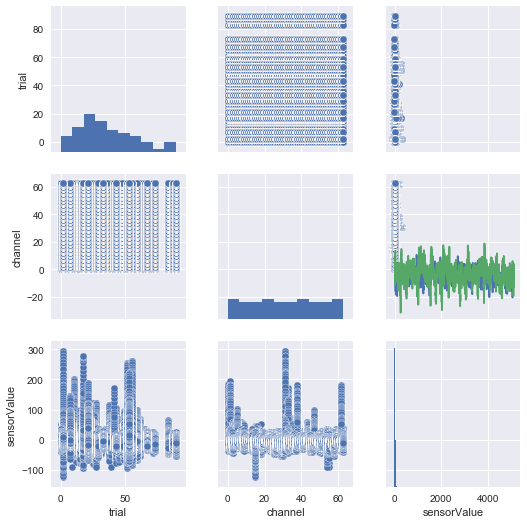

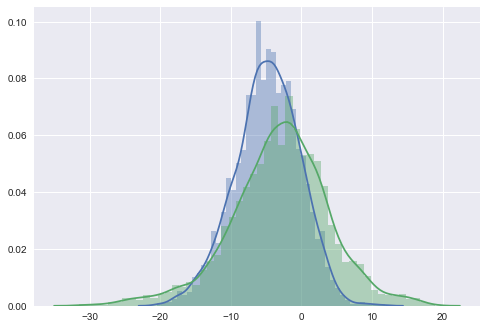

Ttest_relResult(statistic=array([-15.15950286]), pvalue=array([  8.20164346e-51]))


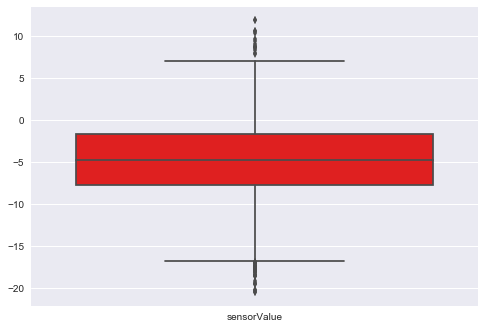

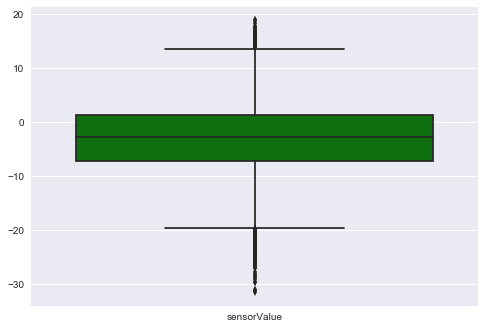

Ttest_1sampResult(statistic=array([-75.03438855]), pvalue=array([ 0.]))
Ttest_indResult(statistic=array([-15.05923331]), pvalue=array([  1.04643612e-50]))
================Sensor Position FZ================================
       sensorValue
count  5120.000000
mean      1.196083
std       5.395867
min     -11.627000
25%      -2.330000
50%       0.498000
75%       3.642000
max      34.485000
       sensorValue
count  5120.000000
mean     -3.740252
std       8.530205
min     -23.824000
25%      -9.145000
50%      -4.893000
75%      -0.142000
max      53.955000


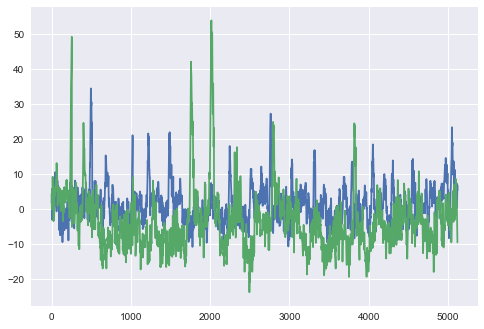

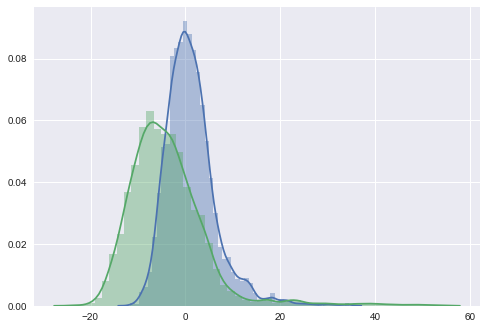

Ttest_relResult(statistic=array([ 34.30592315]), pvalue=array([  2.41326663e-232]))


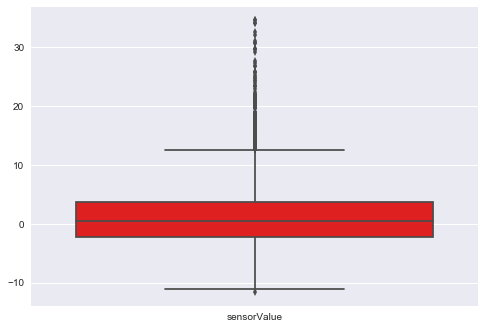

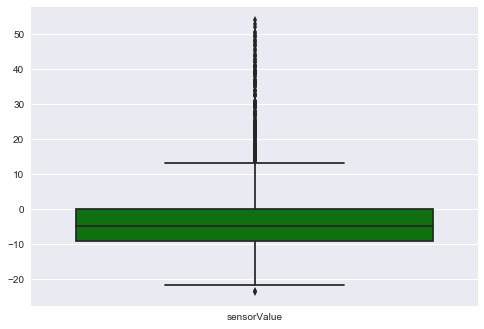

Ttest_1sampResult(statistic=array([ 15.86116317]), pvalue=array([  2.40503106e-55]))
Ttest_indResult(statistic=array([ 34.99416426]), pvalue=array([  1.60177396e-253]))
================Sensor Position Y================================
       sensorValue
count  5120.000000
mean     -6.064127
std       7.945766
min     -36.855000
25%     -11.342000
50%      -6.114000
75%      -0.631000
max      23.132000
       sensorValue
count  5120.000000
mean    -10.444007
std      11.229190
min     -41.901000
25%     -18.656000
50%     -10.742000
75%      -3.052000
max      38.666000


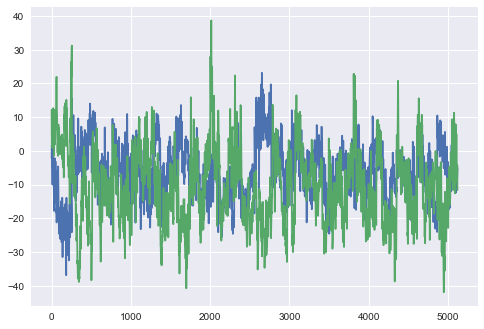

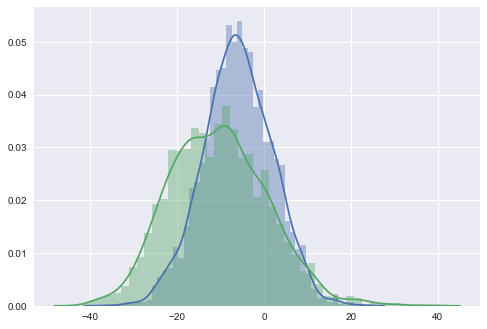

Ttest_relResult(statistic=array([ 21.78583259]), pvalue=array([  1.04906185e-100]))


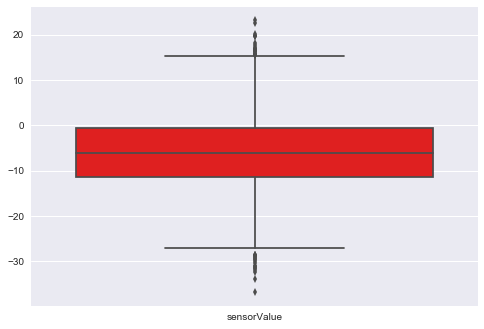

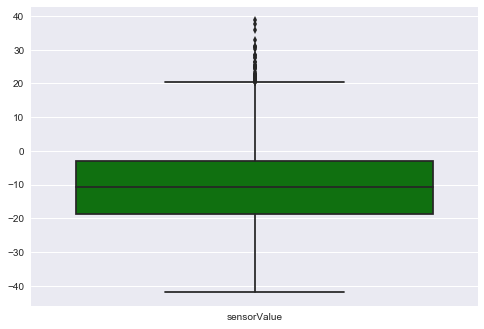

Ttest_1sampResult(statistic=array([-54.60940762]), pvalue=array([ 0.]))
Ttest_indResult(statistic=array([ 22.78255021]), pvalue=array([  4.06584633e-112]))
================Sensor Position CPZ================================
       sensorValue
count  5120.000000
mean     -1.245552
std       2.271290
min     -11.169000
25%      -2.421000
50%      -0.987000
75%       0.224000
max       5.900000
       sensorValue
count  5120.000000
mean      0.206828
std       3.568242
min     -19.297000
25%      -1.709000
50%       0.346000
75%       2.431000
max      10.010000


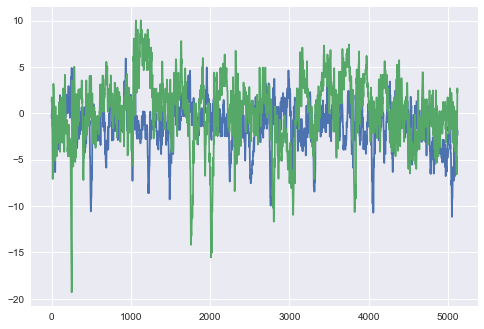

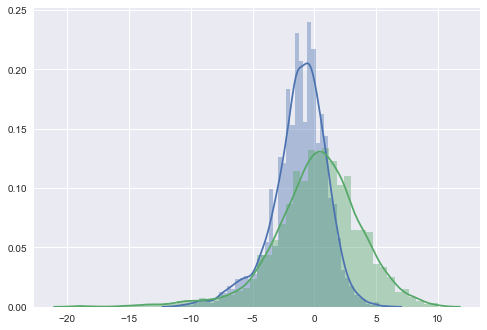

Ttest_relResult(statistic=array([-24.01267831]), pvalue=array([  7.91117439e-121]))


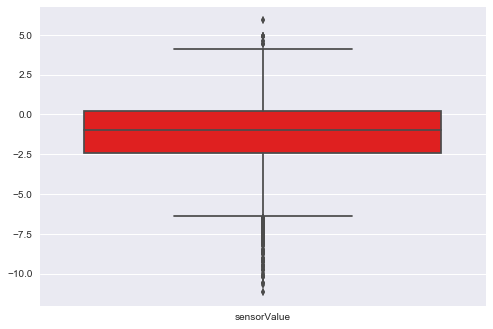

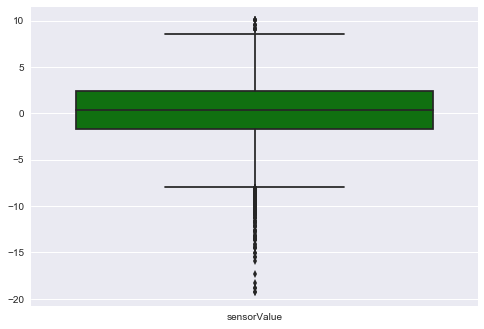

Ttest_1sampResult(statistic=array([-39.23955969]), pvalue=array([  1.12687644e-294]))
Ttest_indResult(statistic=array([-24.56950027]), pvalue=array([  1.44243783e-129]))
================Sensor Position P1================================
       sensorValue
count  5120.000000
mean     -4.135577
std       4.430385
min     -22.990000
25%      -6.632000
50%      -3.886000
75%      -1.221000
max      11.932000
       sensorValue
count  5120.000000
mean     -2.210938
std       7.201149
min     -35.675000
25%      -6.144000
50%      -1.902000
75%       2.218000
max      19.958000


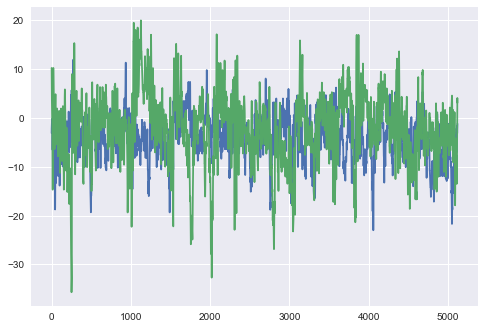

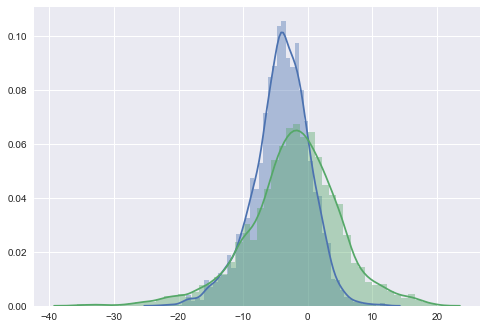

Ttest_relResult(statistic=array([-16.32185628]), pvalue=array([  2.01784902e-58]))


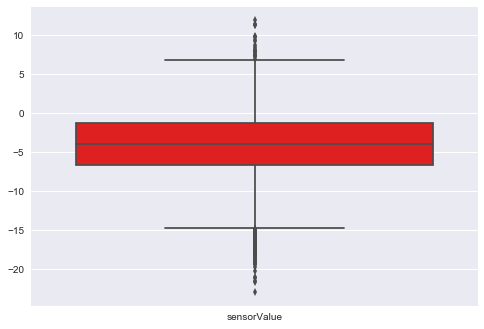

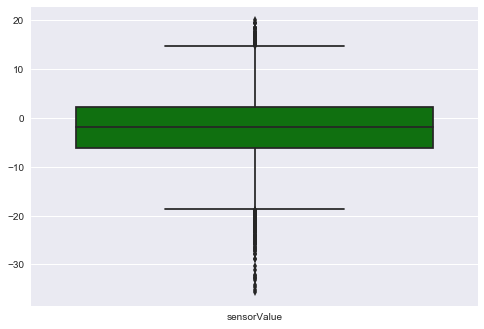

Ttest_1sampResult(statistic=array([-66.79279337]), pvalue=array([ 0.]))
Ttest_indResult(statistic=array([-16.28835213]), pvalue=array([  6.55224755e-59]))
================Sensor Position P6================================
       sensorValue
count  5120.000000
mean     -6.747340
std       5.876491
min     -29.236000
25%     -10.539000
50%      -6.694000
75%      -2.764500
max      10.803000
       sensorValue
count  5120.000000
mean     -5.618224
std       7.363871
min     -42.928000
25%     -10.030000
50%      -5.310000
75%      -0.559000
max      21.108000


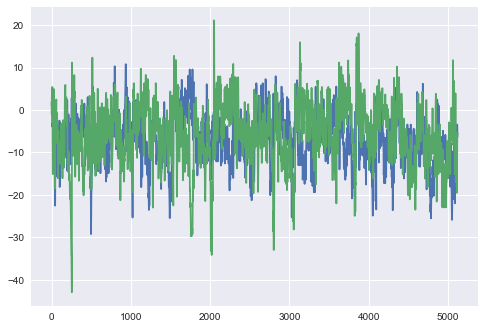

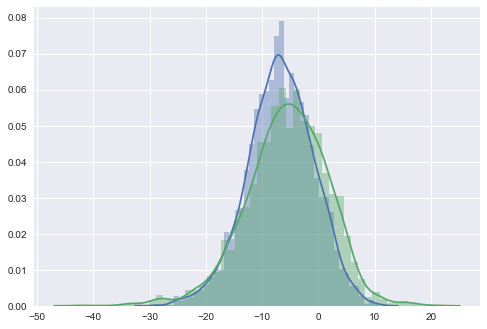

Ttest_relResult(statistic=array([-8.79015061]), pvalue=array([  2.00832320e-18]))


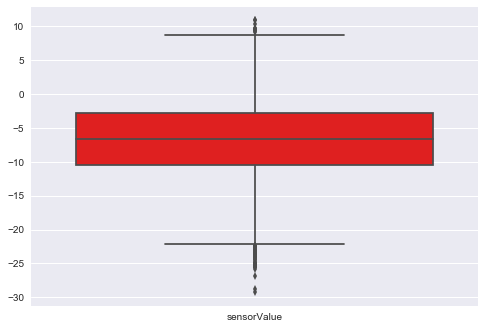

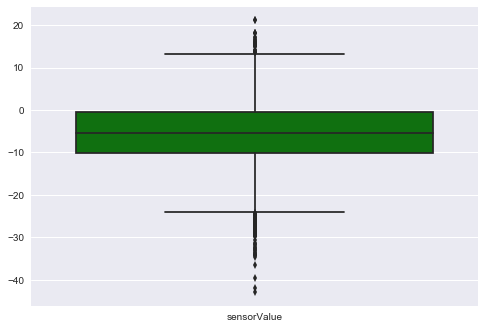

Ttest_1sampResult(statistic=array([-82.15793142]), pvalue=array([ 0.]))
Ttest_indResult(statistic=array([-8.57562033]), pvalue=array([  1.12798009e-17]))
================Sensor Position FP1================================
       sensorValue
count  5120.000000
mean      1.239114
std      16.405473
min     -24.577000
25%      -8.128000
50%      -1.872000
75%       4.344000
max     114.380000
       sensorValue
count  5120.000000
mean     -2.660282
std      20.879979
min     -36.346000
25%     -12.665000
50%      -6.897000
75%       0.916000
max     156.728000


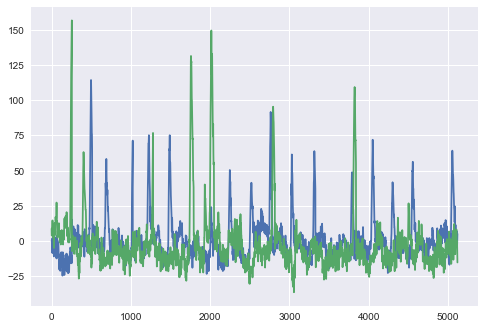

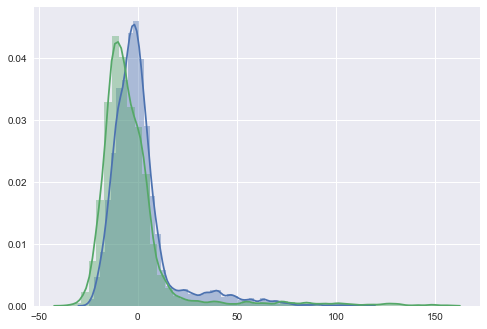

Ttest_relResult(statistic=array([ 10.18758244]), pvalue=array([  3.82401694e-24]))


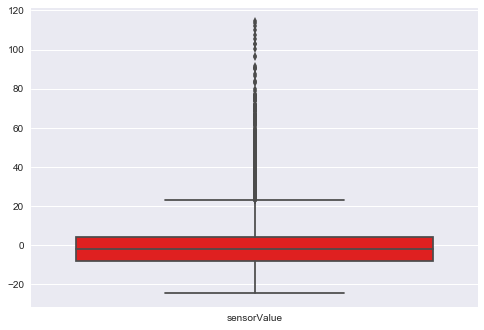

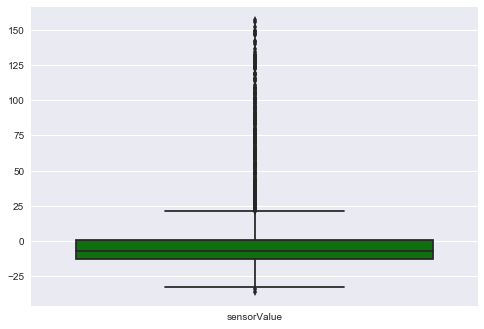

Ttest_1sampResult(statistic=array([ 5.40452405]), pvalue=array([  6.79250912e-08]))
Ttest_indResult(statistic=array([ 10.50758562]), pvalue=array([  1.07690222e-25]))
================Sensor Position O2================================
       sensorValue
count  5120.000000
mean     -8.150737
std       7.279770
min     -35.085000
25%     -12.909000
50%      -8.189000
75%      -3.092000
max      17.537000
       sensorValue
count  5120.000000
mean     -8.779143
std      10.021292
min     -55.298000
25%     -14.547000
50%      -8.433000
75%      -2.340000
max      23.783000


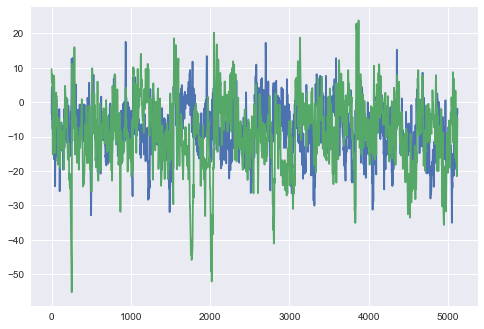

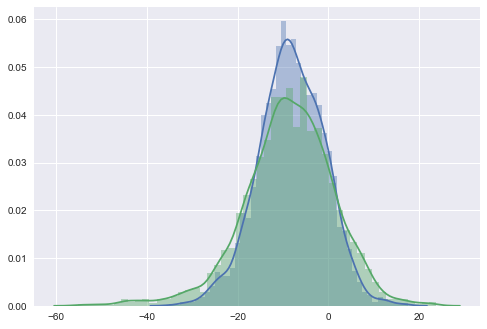

Ttest_relResult(statistic=array([ 3.65006055]), pvalue=array([ 0.00026479]))


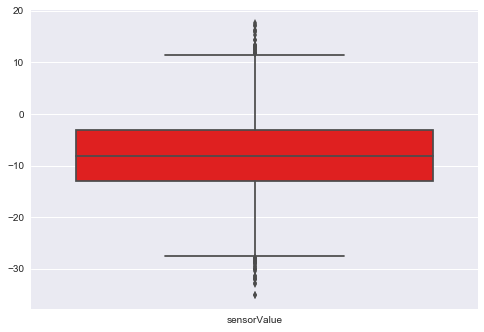

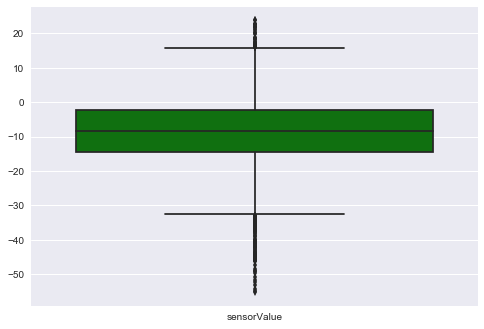

Ttest_1sampResult(statistic=array([-80.11506132]), pvalue=array([ 0.]))
Ttest_indResult(statistic=array([ 3.63021572]), pvalue=array([ 0.00028457]))
================Sensor Position O1================================
       sensorValue
count  5120.000000
mean     -8.059503
std       7.612187
min     -35.817000
25%     -13.072000
50%      -7.884000
75%      -2.818000
max      20.549000
       sensorValue
count  5120.000000
mean     -7.792183
std      10.467080
min     -52.755000
25%     -13.786500
50%      -7.436000
75%      -1.111250
max      27.751000


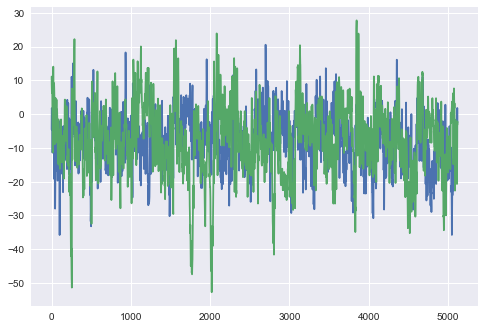

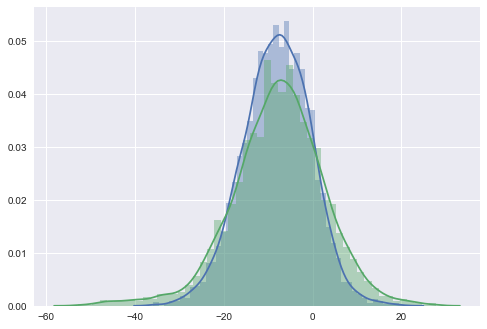

Ttest_relResult(statistic=array([-1.49452709]), pvalue=array([ 0.13509954]))


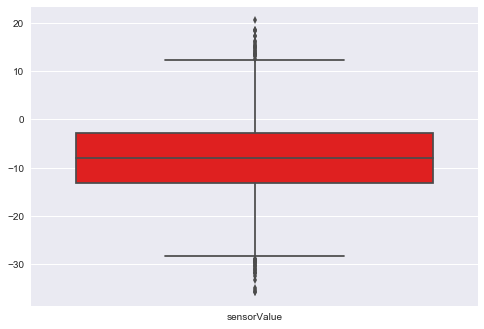

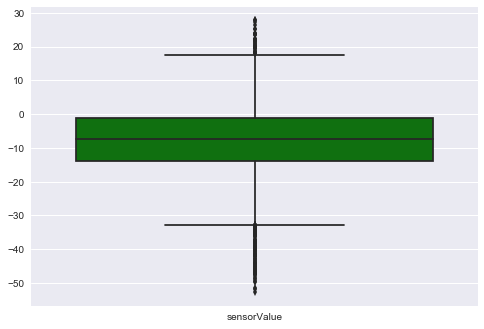

Ttest_1sampResult(statistic=array([-75.7589249]), pvalue=array([ 0.]))
Ttest_indResult(statistic=array([-1.4779276]), pvalue=array([ 0.13945792]))
================Sensor Position P7================================
       sensorValue
count  5120.000000
mean     -7.874490
std       7.117379
min     -34.922000
25%     -12.828000
50%      -7.904000
75%      -3.062000
max      17.446000
       sensorValue
count  5120.000000
mean     -7.176744
std       9.193440
min     -46.672000
25%     -12.838000
50%      -6.866000
75%      -1.251000
max      20.091000


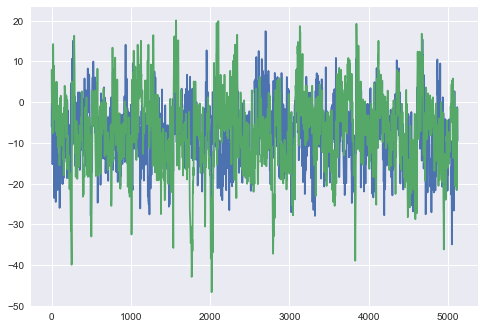

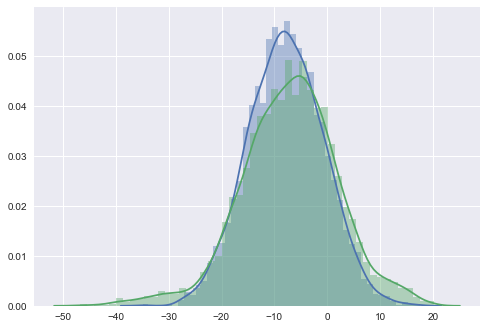

Ttest_relResult(statistic=array([-4.52938111]), pvalue=array([  6.05006953e-06]))


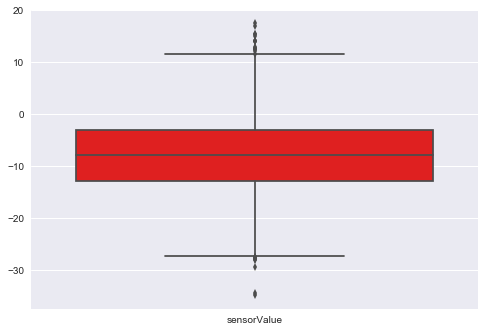

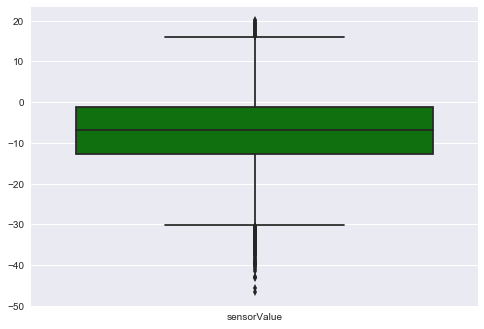

Ttest_1sampResult(statistic=array([-79.16574293]), pvalue=array([ 0.]))
Ttest_indResult(statistic=array([-4.29419524]), pvalue=array([  1.76944398e-05]))
================Sensor Position POZ================================
       sensorValue
count  5120.000000
mean     -5.559163
std       5.831079
min     -29.521000
25%      -8.998000
50%      -5.371000
75%      -1.668000
max      15.076000
       sensorValue
count  5120.000000
mean     -5.216538
std       8.987910
min     -42.155000
25%     -10.244000
50%      -5.025000
75%       0.407000
max      25.523000


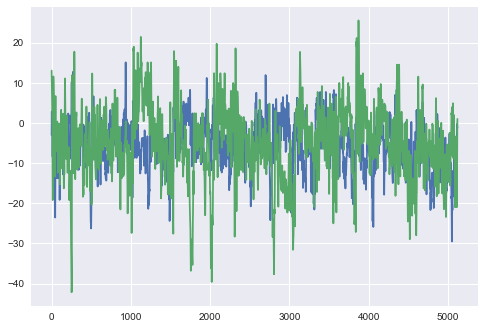

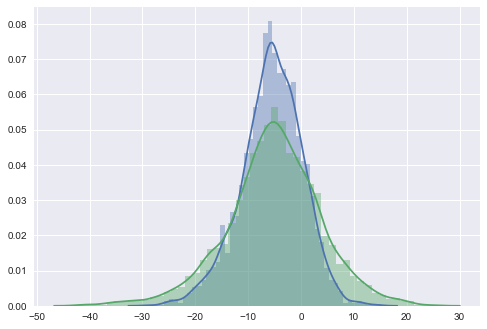

Ttest_relResult(statistic=array([-2.29050206]), pvalue=array([ 0.0220327]))


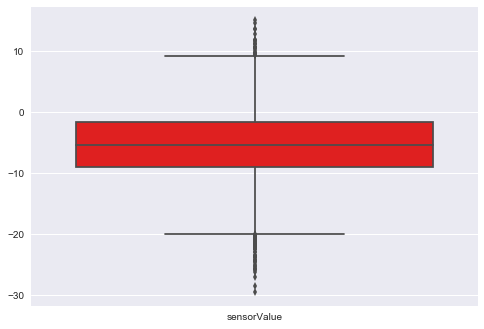

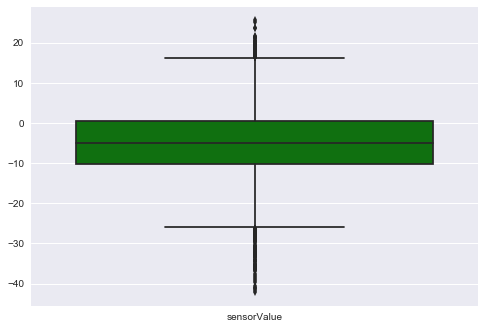

Ttest_1sampResult(statistic=array([-68.21745553]), pvalue=array([ 0.]))
Ttest_indResult(statistic=array([-2.28830598]), pvalue=array([ 0.02213999]))
================Sensor Position P4================================
       sensorValue
count  5120.000000
mean     -4.783667
std       4.530626
min     -23.733000
25%      -7.609000
50%      -4.567000
75%      -1.760000
max      10.132000
       sensorValue
count   5120.00000
mean      -3.68106
std        6.91290
min      -38.67600
25%       -8.14800
50%       -3.37700
75%        1.08800
max       19.26700


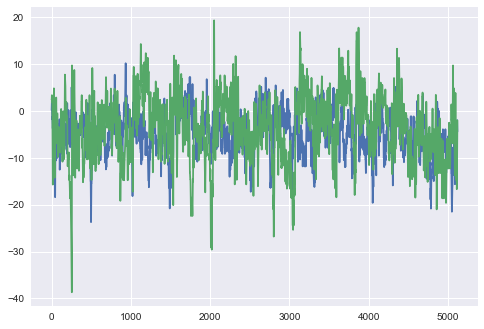

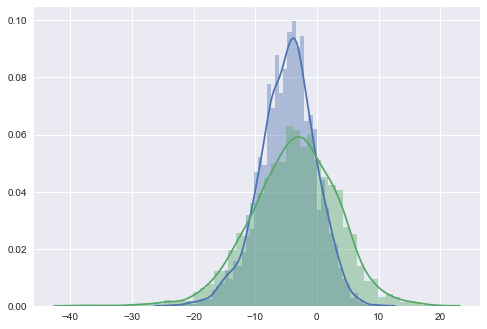

Ttest_relResult(statistic=array([-9.79680636]), pvalue=array([  1.82892736e-22]))


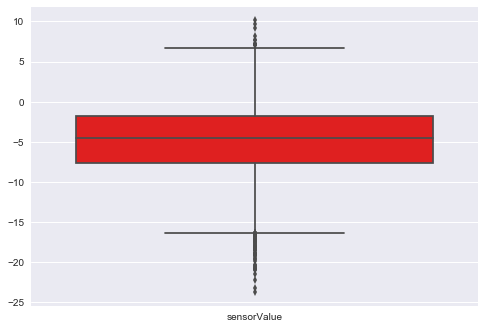

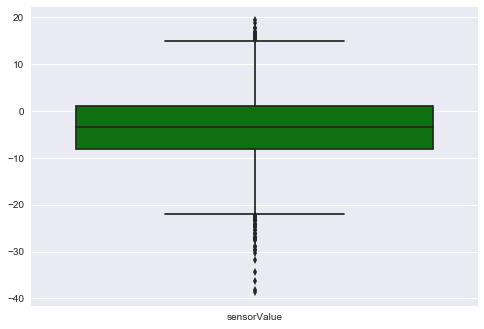

Ttest_1sampResult(statistic=array([-75.5505593]), pvalue=array([ 0.]))
Ttest_indResult(statistic=array([-9.54548843]), pvalue=array([  1.66446865e-21]))
================Sensor Position FT7================================
       sensorValue
count  5120.000000
mean     -4.156498
std       8.909594
min     -37.547000
25%     -10.271750
50%      -4.405000
75%       1.689000
max      25.818000
       sensorValue
count  5120.000000
mean     -6.617477
std       7.937364
min     -30.660000
25%     -12.004000
50%      -6.643000
75%      -1.292000
max      21.088000


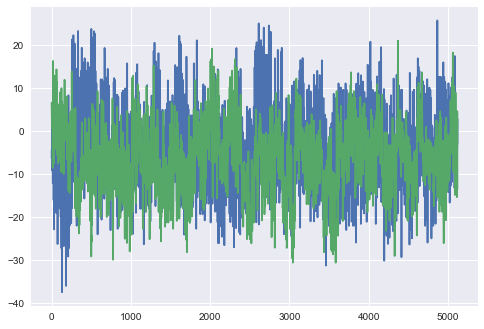

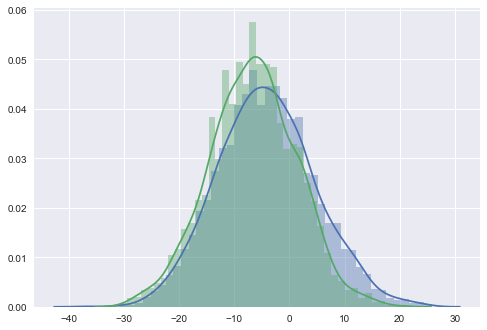

Ttest_relResult(statistic=array([ 14.92337037]), pvalue=array([  2.49800673e-49]))


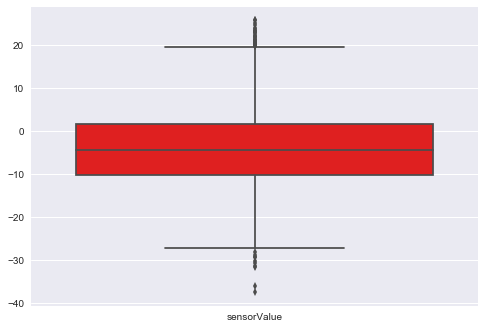

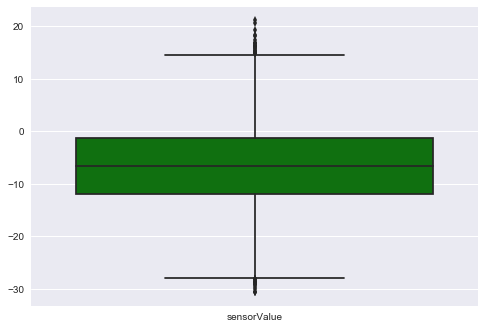

Ttest_1sampResult(statistic=array([-33.38140938]), pvalue=array([  3.13355799e-221]))
Ttest_indResult(statistic=array([ 14.75755333]), pvalue=array([  8.70957835e-49]))
================Sensor Position PZ================================
       sensorValue
count  5120.000000
mean     -3.027212
std       4.045148
min     -19.887000
25%      -5.292500
50%      -2.736500
75%      -0.468000
max      10.295000
       sensorValue
count  5120.000000
mean     -1.696615
std       7.279488
min     -36.326000
25%      -6.195000
50%      -1.643000
75%       3.215000
max      20.660000


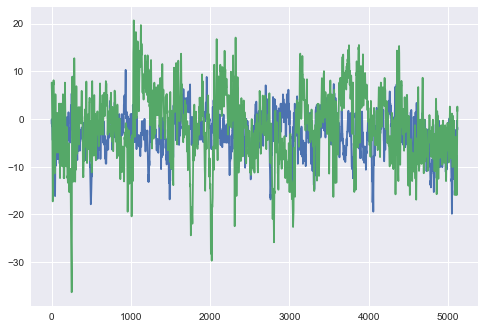

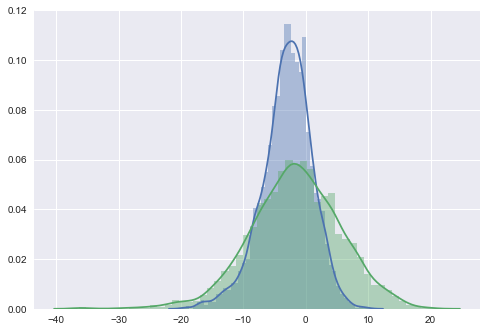

Ttest_relResult(statistic=array([-11.31069414]), pvalue=array([  2.58153648e-29]))


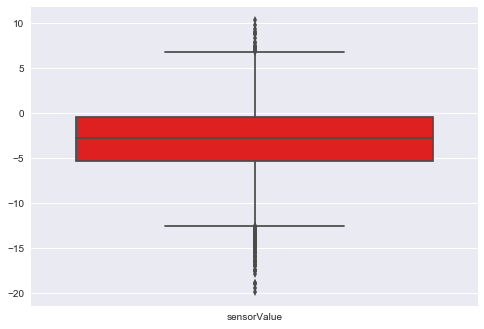

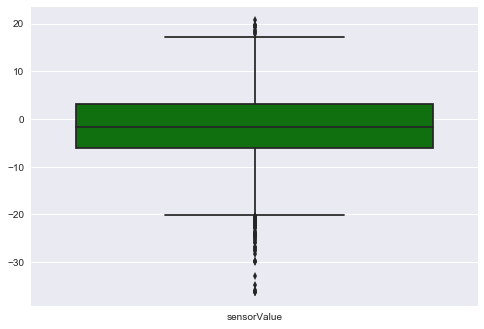

Ttest_1sampResult(statistic=array([-53.54801139]), pvalue=array([ 0.]))
Ttest_indResult(statistic=array([-11.43260353]), pvalue=array([  4.37338117e-30]))
================Sensor Position FT8================================
       sensorValue
count  5120.000000
mean     -3.428419
std       5.974880
min     -24.994000
25%      -7.416000
50%      -3.530000
75%       0.381250
max      19.165000
       sensorValue
count  5120.000000
mean     -6.446998
std       8.799999
min     -38.788000
25%     -12.299000
50%      -6.551000
75%      -0.580000
max      32.644000


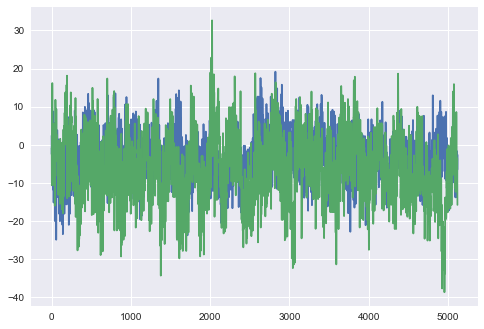

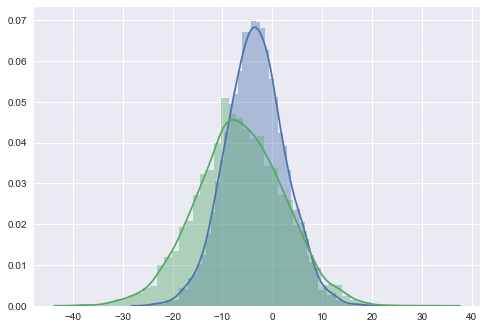

Ttest_relResult(statistic=array([ 20.89842295]), pvalue=array([  3.89216277e-93]))


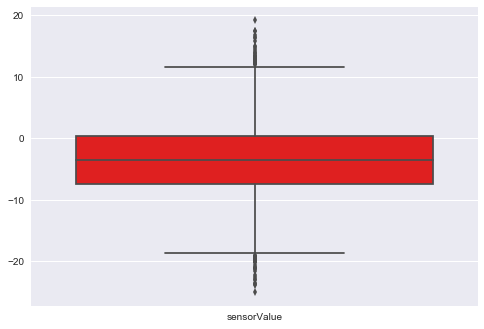

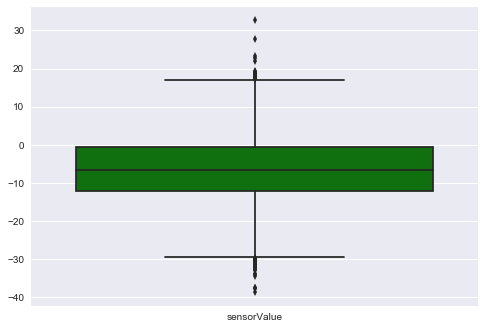

Ttest_1sampResult(statistic=array([-41.05817765]), pvalue=array([ 0.]))
Ttest_indResult(statistic=array([ 20.30630844]), pvalue=array([  6.57886113e-90]))
================Sensor Position FCZ================================
       sensorValue
count  5120.000000
mean      0.977837
std       2.682489
min      -7.914000
25%      -0.732000
50%       0.829000
75%       2.533000
max      12.807000
       sensorValue
count  5120.000000
mean     -2.346107
std       4.136924
min     -13.377000
25%      -5.157000
50%      -2.675000
75%       0.203000
max      19.358000


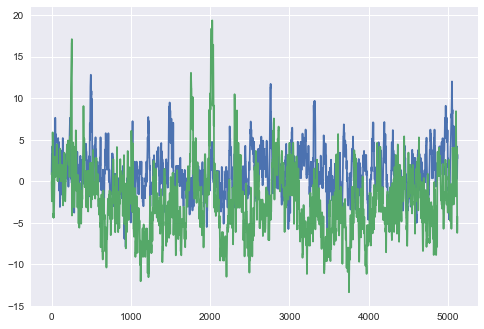

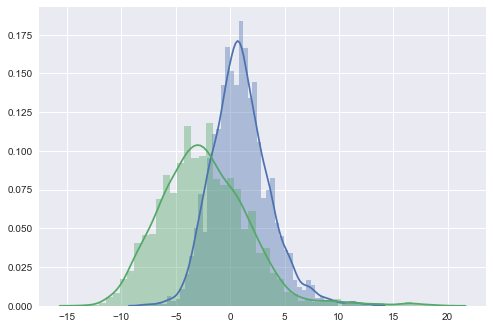

Ttest_relResult(statistic=array([ 48.92302074]), pvalue=array([ 0.]))


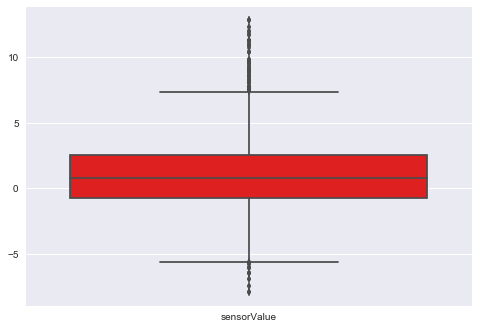

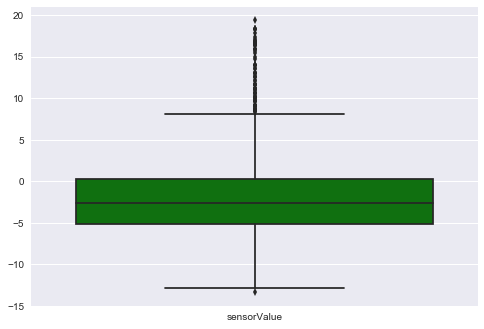

Ttest_1sampResult(statistic=array([ 26.08336405]), pvalue=array([  6.36124863e-141]))
Ttest_indResult(statistic=array([ 48.23888765]), pvalue=array([ 0.]))
================Sensor Position nd================================
       sensorValue
count  5120.000000
mean      1.293718
std      16.092510
min     -23.346000
25%      -7.751000
50%      -1.811000
75%       4.272000
max     111.888000
       sensorValue
count  5120.000000
mean     -2.778465
std      20.501489
min     -35.960000
25%     -12.655000
50%      -6.927000
75%       0.529000
max     153.168000


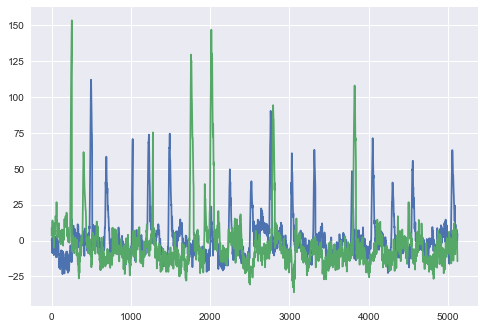

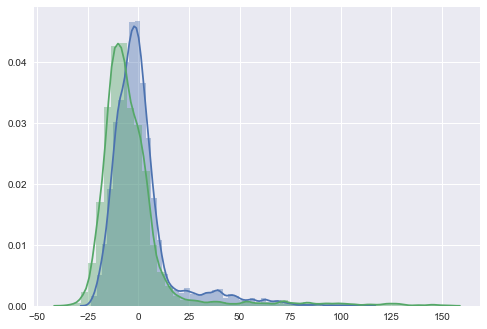

Ttest_relResult(statistic=array([ 10.85725757]), pvalue=array([  3.63486060e-27]))


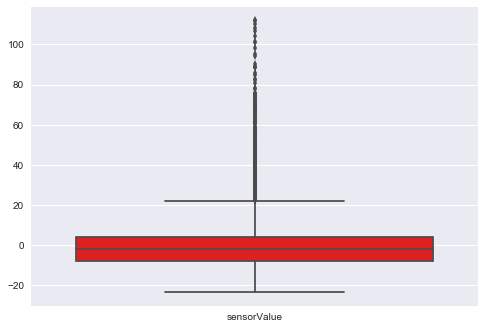

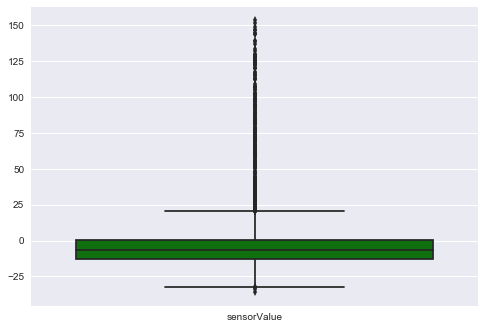

Ttest_1sampResult(statistic=array([ 5.75242118]), pvalue=array([  9.30813218e-09]))
Ttest_indResult(statistic=array([ 11.17989904]), pvalue=array([  7.51268303e-29]))
================Sensor Position TP7================================
       sensorValue
count  5120.000000
mean     -6.965830
std       7.360054
min     -32.471000
25%     -11.965500
50%      -7.039000
75%      -1.801000
max      26.316000
       sensorValue
count  5120.000000
mean     -6.895196
std       8.011946
min     -39.337000
25%     -12.085000
50%      -6.541000
75%      -1.506000
max      18.728000


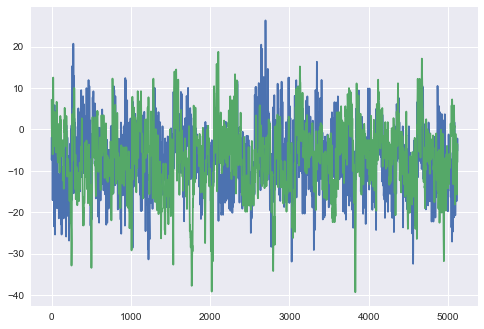

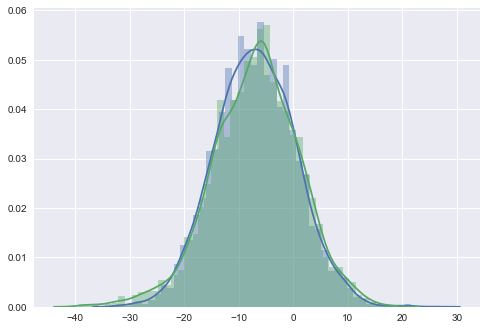

Ttest_relResult(statistic=array([-0.4924086]), pvalue=array([ 0.62245164]))


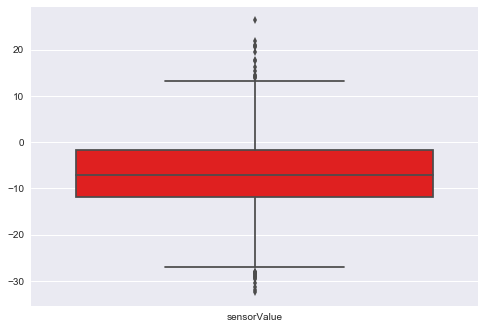

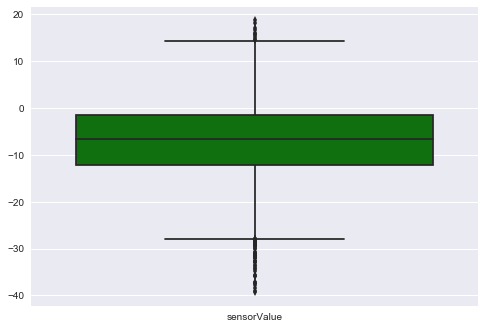

Ttest_1sampResult(statistic=array([-67.72154777]), pvalue=array([ 0.]))
Ttest_indResult(statistic=array([-0.46456143]), pvalue=array([ 0.64225543]))
================Sensor Position OZ================================
       sensorValue
count  5120.000000
mean     -7.914446
std       7.359834
min     -35.258000
25%     -12.655000
50%      -7.863000
75%      -2.981000
max      20.223000
       sensorValue
count  5120.000000
mean     -8.290614
std      10.520413
min     -53.355000
25%     -14.170000
50%      -7.802000
75%      -1.607000
max      26.428000


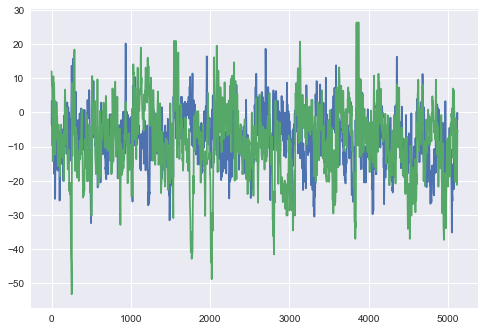

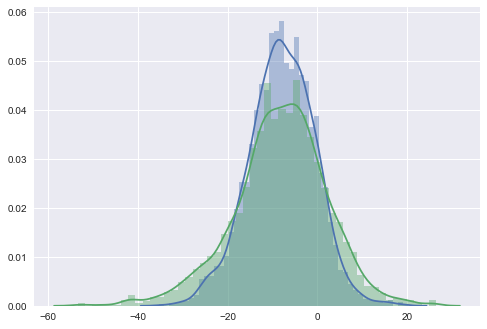

Ttest_relResult(statistic=array([ 2.12074757]), pvalue=array([ 0.033991]))


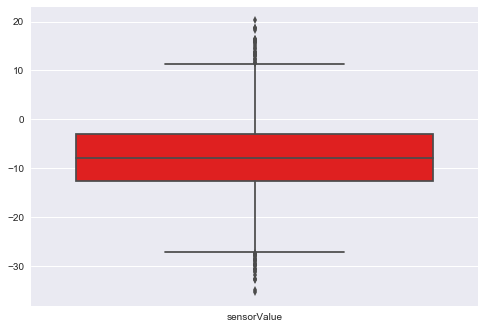

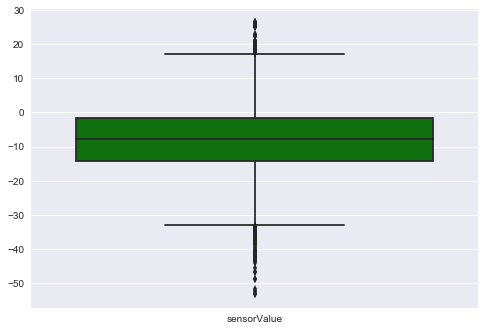

Ttest_1sampResult(statistic=array([-76.94625056]), pvalue=array([ 0.]))
Ttest_indResult(statistic=array([ 2.096416]), pvalue=array([ 0.03606978]))
================Sensor Position AF8================================
       sensorValue
count  5120.000000
mean      0.237434
std      13.927885
min     -33.549000
25%      -8.341000
50%      -1.434000
75%       6.276250
max     104.940000
       sensorValue
count  5120.000000
mean     -2.672583
std      24.057878
min     -45.227000
25%     -13.494000
50%      -7.273000
75%       0.264000
max     171.366000


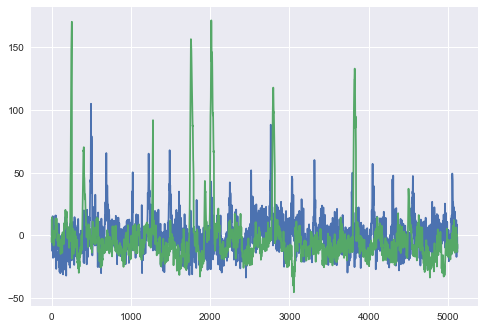

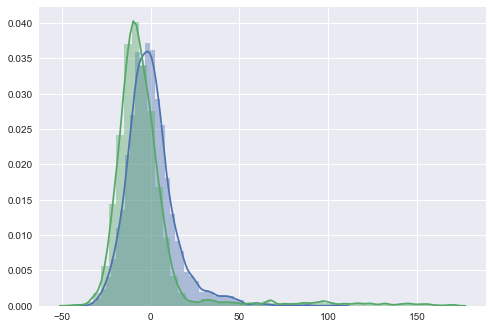

Ttest_relResult(statistic=array([ 7.41293584]), pvalue=array([  1.43773197e-13]))


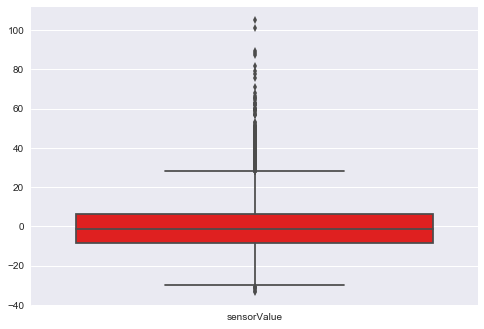

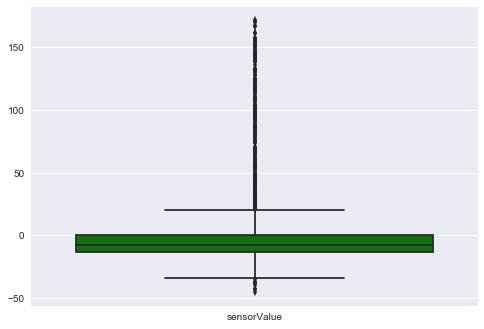

Ttest_1sampResult(statistic=array([ 1.2198114]), pvalue=array([ 0.22259257]))
Ttest_indResult(statistic=array([ 7.49041769]), pvalue=array([  7.43207939e-14]))
================Sensor Position FP2================================
       sensorValue
count  5120.000000
mean      1.530269
std      16.300795
min     -25.930000
25%      -7.650000
50%      -1.475000
75%       5.051000
max     121.277000
       sensorValue
count  5120.000000
mean     -1.847245
std      24.731120
min     -38.055000
25%     -12.868000
50%      -6.744500
75%       1.109000
max     180.796000


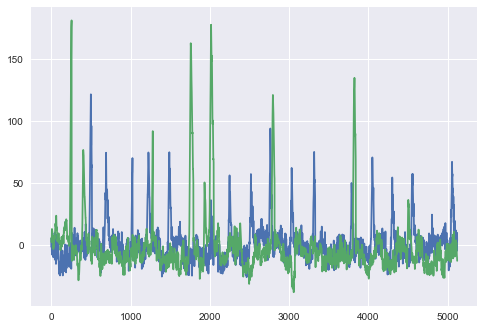

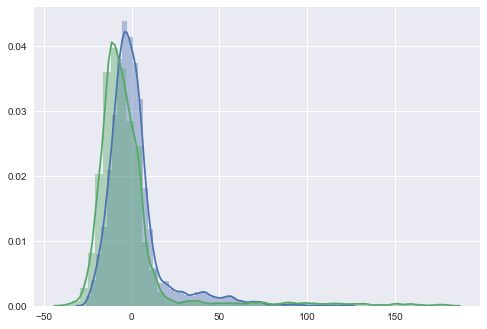

Ttest_relResult(statistic=array([ 7.94010462]), pvalue=array([  2.46394578e-15]))


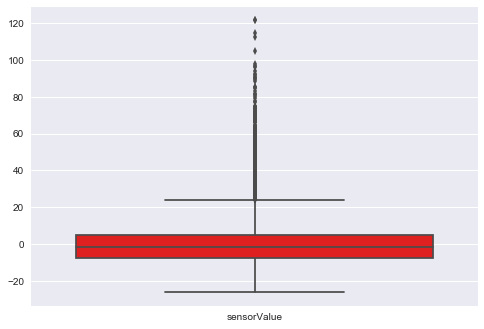

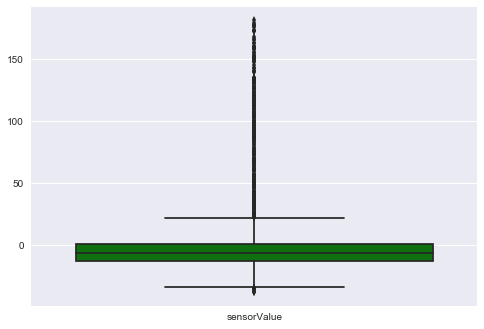

Ttest_1sampResult(statistic=array([ 6.7172861]), pvalue=array([  2.05267217e-11]))
Ttest_indResult(statistic=array([ 8.15918943]), pvalue=array([  3.76865305e-16]))
================Sensor Position C3================================
       sensorValue
count  5120.000000
mean     -2.203844
std       6.124907
min     -39.795000
25%      -4.995000
50%      -2.355000
75%       0.264000
max      36.051000
       sensorValue
count  5120.000000
mean     -2.455681
std       3.827000
min     -19.969000
25%      -4.934000
50%      -2.492000
75%       0.081000
max      10.874000


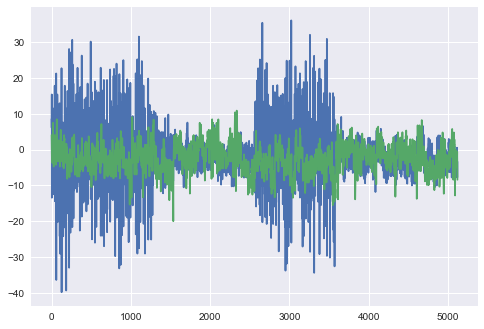

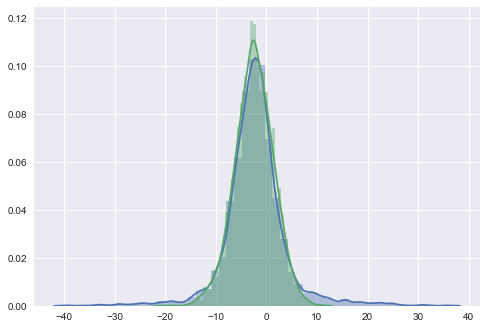

Ttest_relResult(statistic=array([ 2.55418756]), pvalue=array([ 0.0106723]))


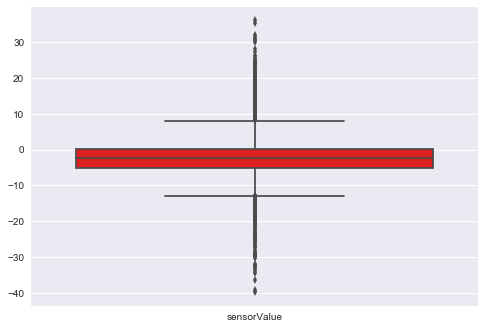

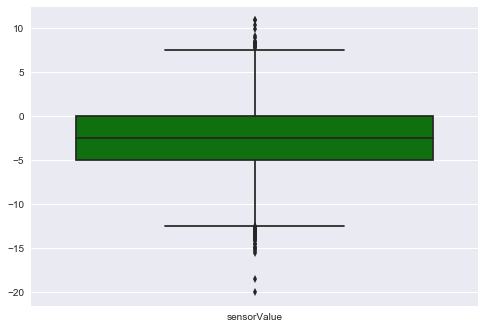

Ttest_1sampResult(statistic=array([-25.74639171]), pvalue=array([  1.44935064e-137]))
Ttest_indResult(statistic=array([ 2.49507453]), pvalue=array([ 0.0126087]))
================Sensor Position C2================================
       sensorValue
count  5120.000000
mean      0.144060
std       2.099661
min      -9.410000
25%      -1.243750
50%       0.081000
75%       1.434000
max      10.925000
       sensorValue
count  5120.000000
mean     -1.111789
std       4.206095
min     -16.032000
25%      -3.916000
50%      -1.261000
75%       1.424000
max      17.629000


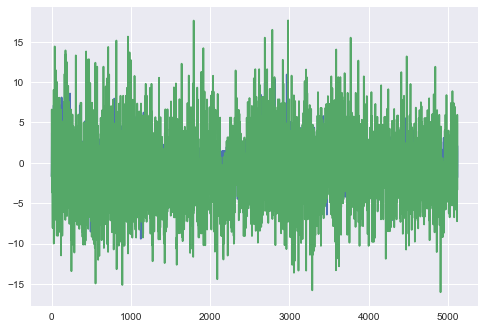

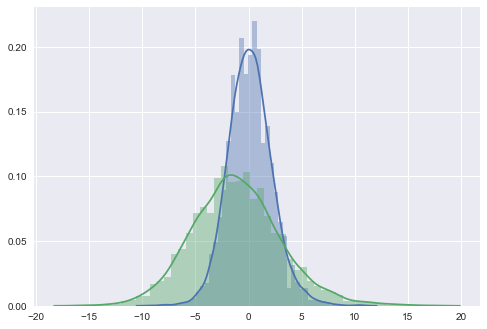

Ttest_relResult(statistic=array([ 19.7274548]), pvalue=array([  1.48667243e-83]))


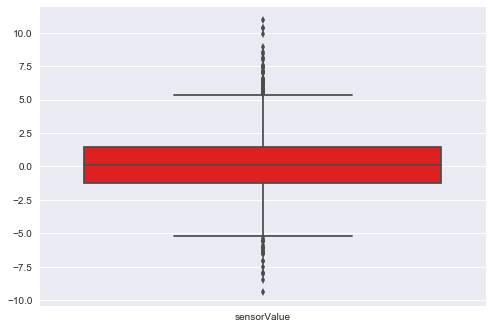

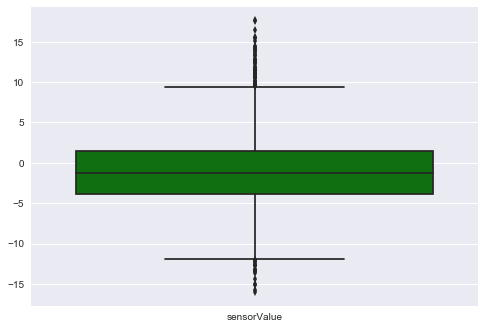

Ttest_1sampResult(statistic=array([ 4.90942145]), pvalue=array([  9.41833404e-07]))
Ttest_indResult(statistic=array([ 19.11517319]), pvalue=array([  4.64134350e-80]))
================Sensor Position C1================================
       sensorValue
count  5120.000000
mean     -0.609116
std       2.616856
min     -15.147000
25%      -2.146000
50%      -0.570000
75%       0.895000
max      12.665000
       sensorValue
count  5120.000000
mean     -0.747901
std       3.205461
min     -15.828000
25%      -2.777000
50%      -0.641000
75%       1.312000
max       9.878000


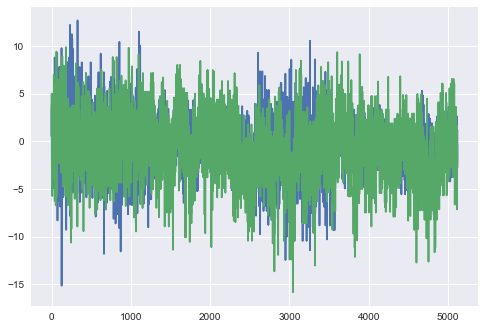

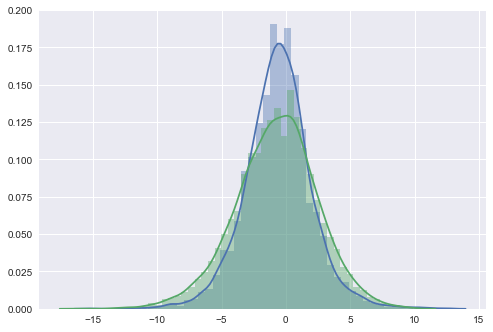

Ttest_relResult(statistic=array([ 2.53560083]), pvalue=array([ 0.01125496]))


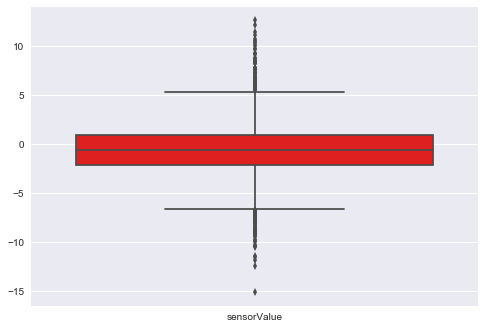

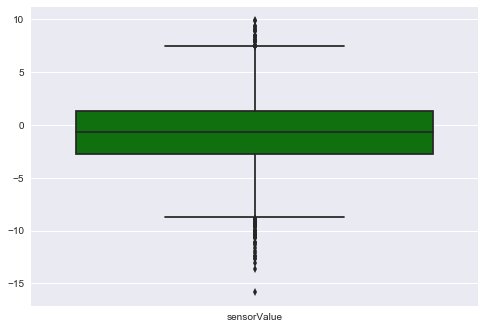

Ttest_1sampResult(statistic=array([-16.65539599]), pvalue=array([  1.06813243e-60]))
Ttest_indResult(statistic=array([ 2.39987102]), pvalue=array([ 0.0164186]))
================Sensor Position AF7================================
       sensorValue
count  5120.000000
mean     -0.242899
std      13.569091
min     -31.789000
25%      -8.270000
50%      -2.167000
75%       4.201000
max      84.981000
       sensorValue
count  5120.000000
mean     -4.030458
std      16.658542
min     -32.623000
25%     -12.950000
50%      -7.233000
75%       0.071000
max     118.479000


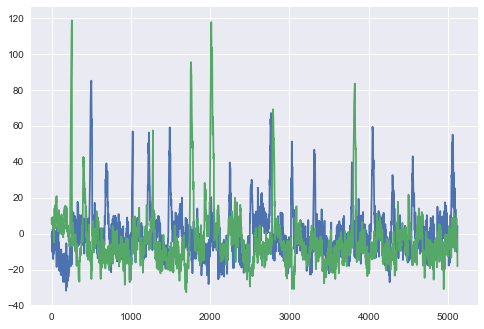

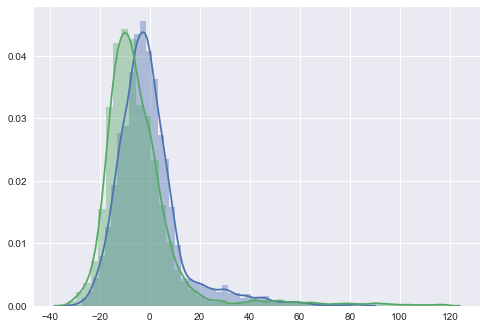

Ttest_relResult(statistic=array([ 12.16582738]), pvalue=array([  1.36947693e-33]))


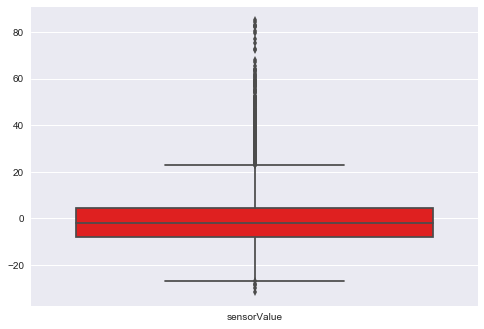

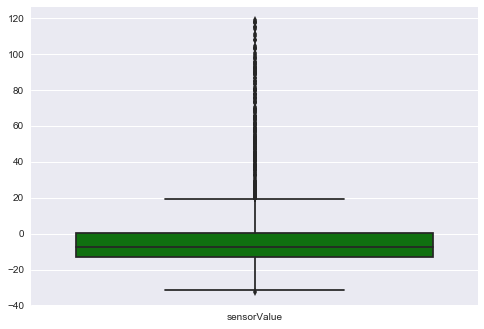

Ttest_1sampResult(statistic=array([-1.28088249]), pvalue=array([ 0.20029297]))
Ttest_indResult(statistic=array([ 12.61388167]), pvalue=array([  3.28978768e-36]))
================Sensor Position C6================================
       sensorValue
count  5120.000000
mean     -2.371727
std       3.556693
min     -13.916000
25%      -4.873000
50%      -2.513000
75%      -0.142000
max      11.912000
       sensorValue
count  5120.000000
mean     -4.514252
std       6.733284
min     -30.131000
25%      -8.993000
50%      -4.527000
75%      -0.031000
max      20.477000


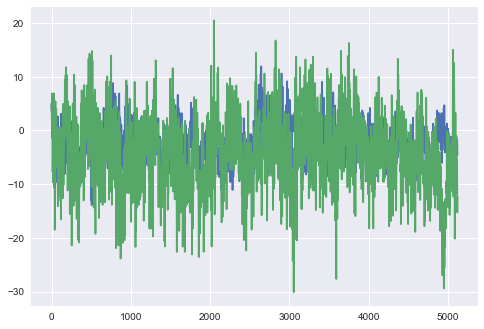

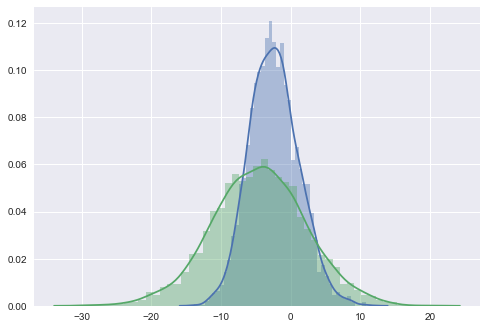

Ttest_relResult(statistic=array([ 20.42278155]), pvalue=array([  3.45680316e-89]))


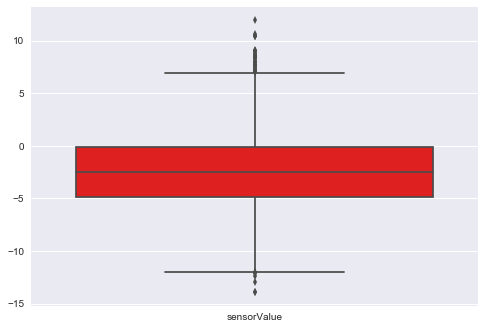

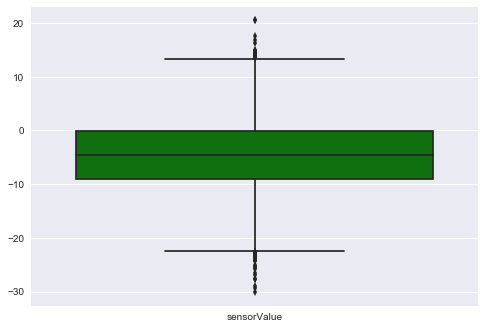

Ttest_1sampResult(statistic=array([-47.71483]), pvalue=array([ 0.]))
Ttest_indResult(statistic=array([ 20.13236813]), pvalue=array([  1.95195647e-88]))
================Sensor Position C5================================
       sensorValue
count  5120.000000
mean     -3.598246
std       5.332873
min     -25.675000
25%      -7.039000
50%      -3.774000
75%      -0.376000
max      21.749000
       sensorValue
count  5120.000000
mean     -4.581454
std       5.729438
min     -23.417000
25%      -8.413000
50%      -4.415000
75%      -0.824000
max      14.048000


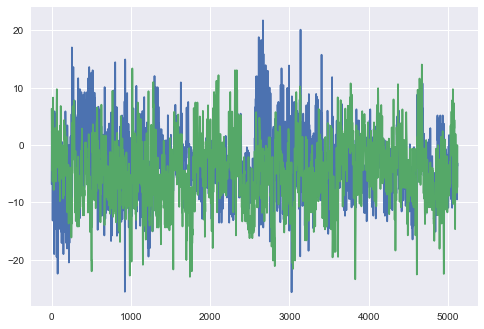

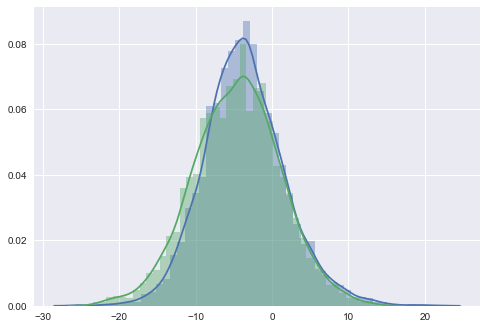

Ttest_relResult(statistic=array([ 9.25772074]), pvalue=array([  3.00250238e-20]))


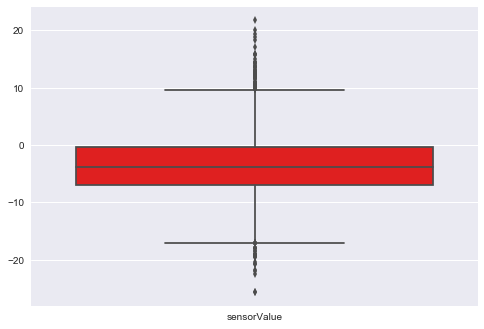

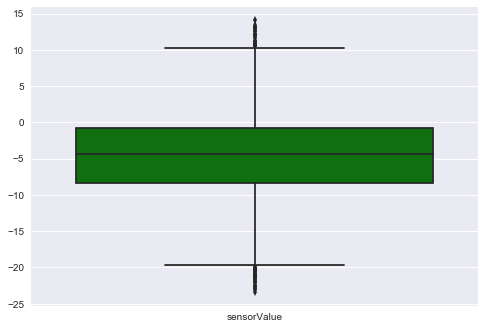

Ttest_1sampResult(statistic=array([-48.27969529]), pvalue=array([ 0.]))
Ttest_indResult(statistic=array([ 8.98816434]), pvalue=array([  2.95735740e-19]))
================Sensor Position C4================================
       sensorValue
count  5120.000000
mean     -0.673136
std       4.023122
min     -21.057000
25%      -3.245000
50%      -0.936000
75%       1.495000
max      20.549000
       sensorValue
count  5120.000000
mean     -2.189241
std       5.101822
min     -18.148000
25%      -5.442000
50%      -2.207000
75%       1.434000
max      13.855000


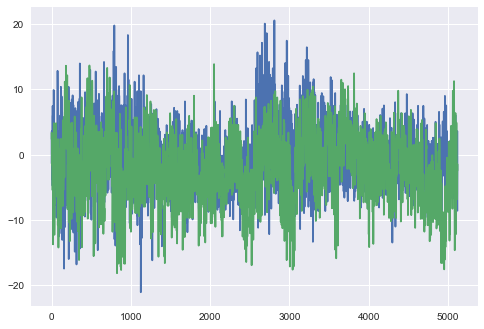

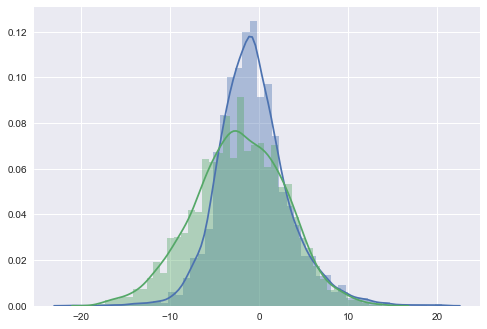

Ttest_relResult(statistic=array([ 17.32881745]), pvalue=array([  2.03380639e-65]))


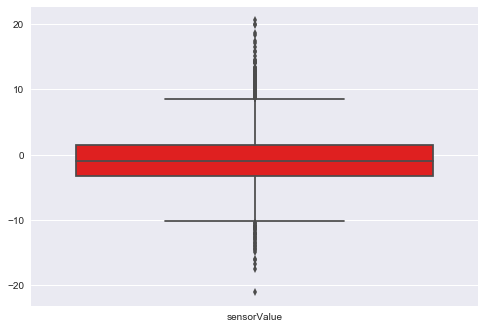

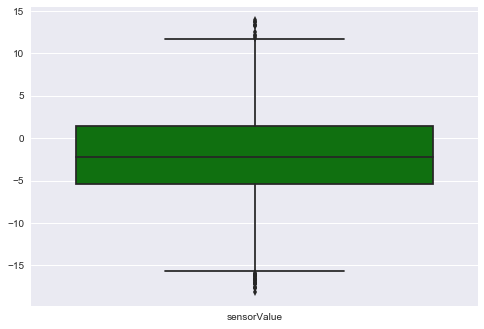

Ttest_1sampResult(statistic=array([-11.97221427]), pvalue=array([  1.34890663e-32]))
Ttest_indResult(statistic=array([ 16.69689485]), pvalue=array([  9.02571527e-62]))
================Sensor Position P2================================
       sensorValue
count  5120.000000
mean     -3.946470
std       4.495657
min     -22.085000
25%      -6.658000
50%      -3.754000
75%      -0.916000
max      10.305000
       sensorValue
count  5120.000000
mean     -2.608454
std       9.697880
min     -38.045000
25%      -8.626000
50%      -2.452000
75%       3.499000
max      34.841000


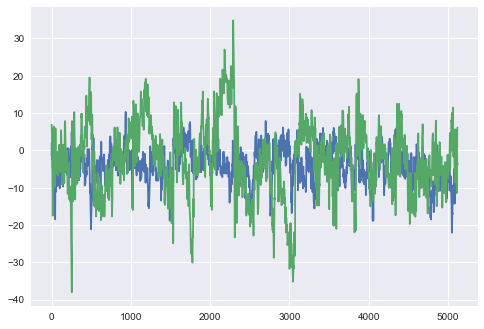

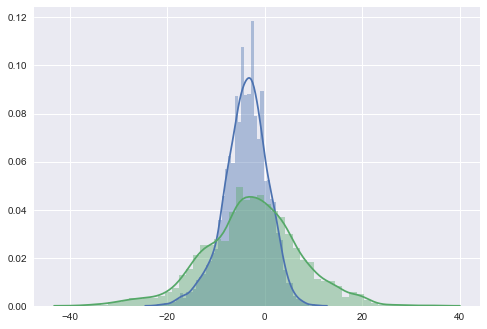

Ttest_relResult(statistic=array([-8.93391157]), pvalue=array([  5.63802840e-19]))


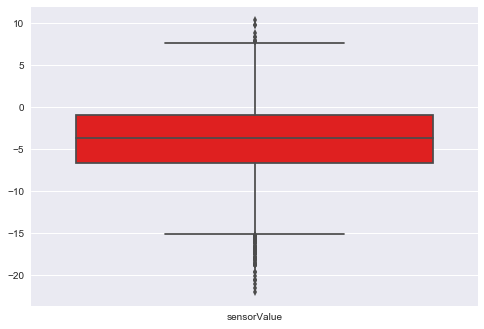

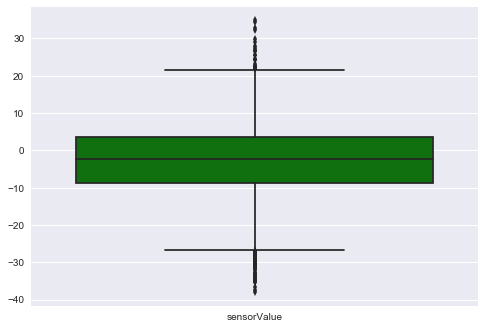

Ttest_1sampResult(statistic=array([-62.81315992]), pvalue=array([ 0.]))
Ttest_indResult(statistic=array([-8.95673372]), pvalue=array([  3.92552142e-19]))
================Sensor Position FC1================================
       sensorValue
count  5120.000000
mean     -0.111613
std       2.897663
min      -8.738000
25%      -1.943000
50%      -0.336000
75%       1.617000
max      18.504000
       sensorValue
count  5120.000000
mean     -2.129459
std       4.597536
min     -19.348000
25%      -5.157000
50%      -2.452000
75%       0.427000
max      24.841000


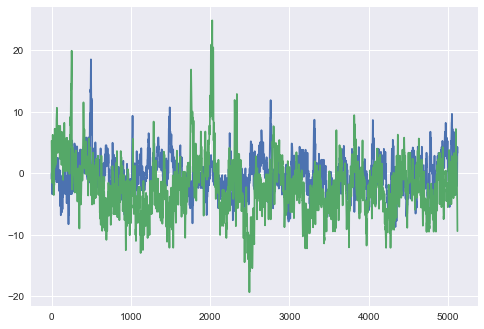

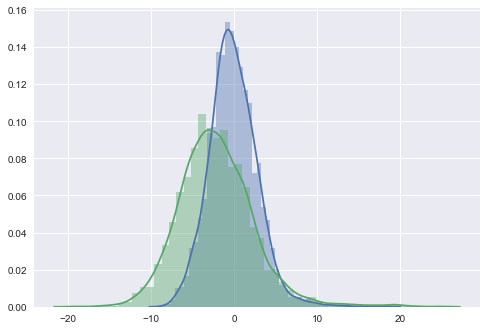

Ttest_relResult(statistic=array([ 27.09900592]), pvalue=array([  3.04692505e-151]))


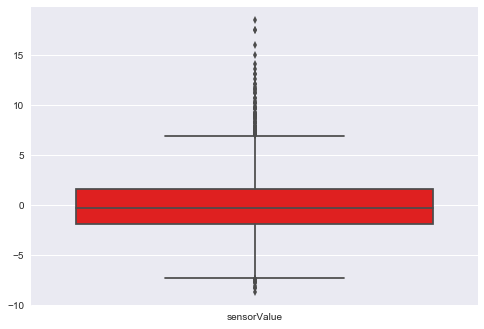

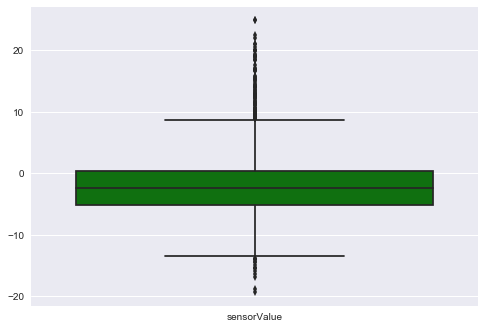

Ttest_1sampResult(statistic=array([-2.75614158]), pvalue=array([ 0.00586948]))
Ttest_indResult(statistic=array([ 26.56828563]), pvalue=array([  1.84466296e-150]))
================Sensor Position FC2================================
       sensorValue
count  5120.000000
mean      0.771806
std       2.617368
min      -7.609000
25%      -0.936000
50%       0.559000
75%       2.289000
max      13.519000
       sensorValue
count  5120.000000
mean     -2.319238
std       4.751462
min     -13.692000
25%      -5.534000
50%      -2.747000
75%       0.193000
max      25.503000


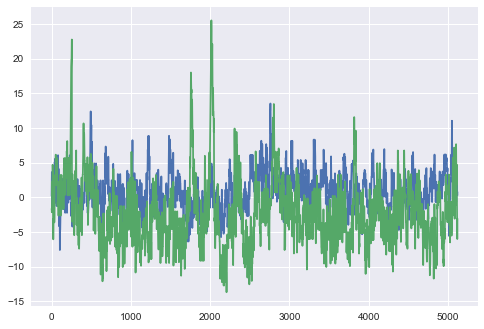

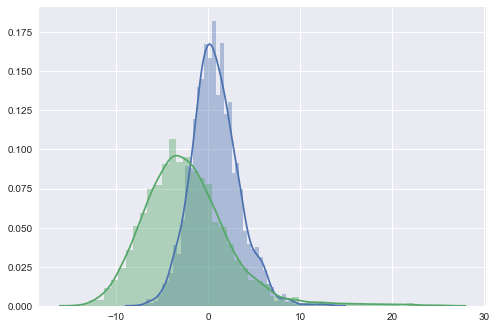

Ttest_relResult(statistic=array([ 41.56198813]), pvalue=array([ 0.]))


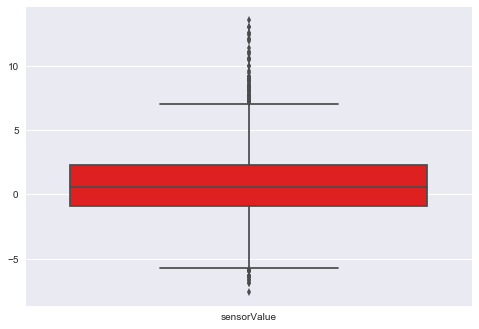

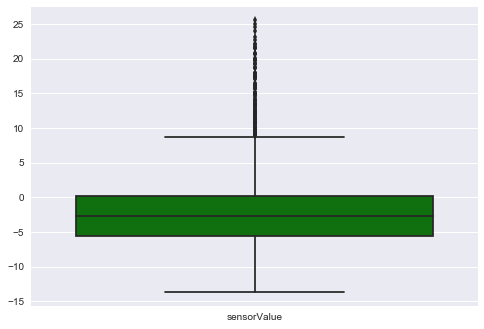

Ttest_1sampResult(statistic=array([ 21.09979363]), pvalue=array([  7.86264368e-95]))
Ttest_indResult(statistic=array([ 40.77247922]), pvalue=array([ 0.]))
================Sensor Position FC3================================
       sensorValue
count  5120.000000
mean     -0.953352
std       3.408235
min     -13.123000
25%      -3.153000
50%      -1.129000
75%       1.241000
max      17.314000
       sensorValue
count  5120.000000
mean     -3.567212
std       5.237147
min     -21.230000
25%      -6.989000
50%      -3.733000
75%      -0.102000
max      22.410000


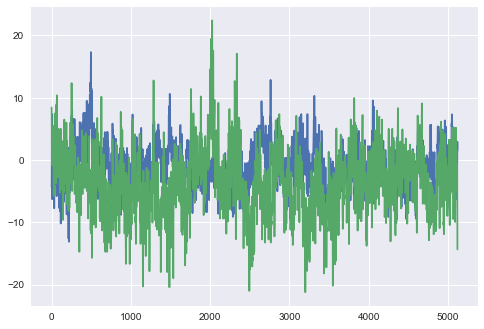

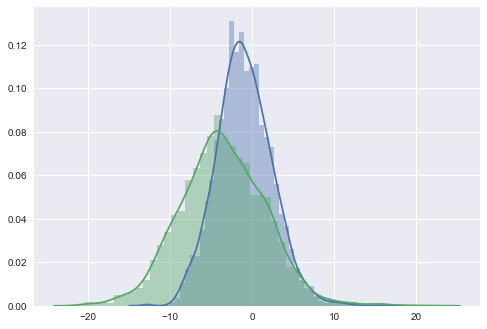

Ttest_relResult(statistic=array([ 30.17489405]), pvalue=array([  3.03551601e-184]))


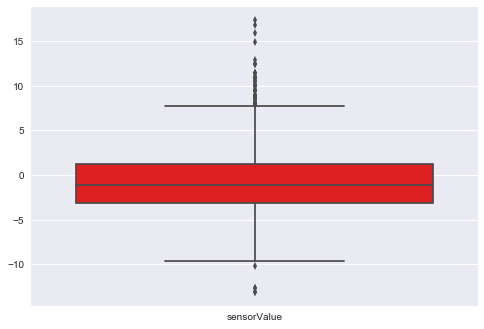

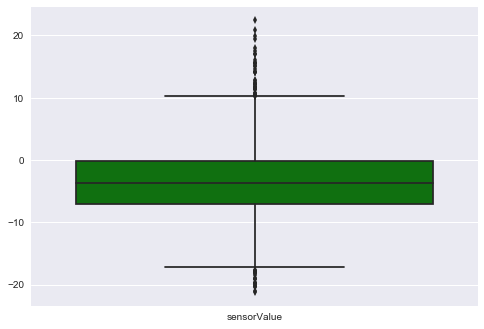

Ttest_1sampResult(statistic=array([-20.01514587]), pvalue=array([  7.26850159e-86]))
Ttest_indResult(statistic=array([ 29.93238836]), pvalue=array([  8.66116940e-189]))
================Sensor Position FC4================================
       sensorValue
count  5120.000000
mean     -0.261564
std       3.526229
min     -12.268000
25%      -2.533000
50%      -0.326000
75%       1.892000
max      17.324000
       sensorValue
count  5120.000000
mean     -3.247929
std       6.407043
min     -23.783000
25%      -7.558000
50%      -3.347000
75%       0.743000
max      25.085000


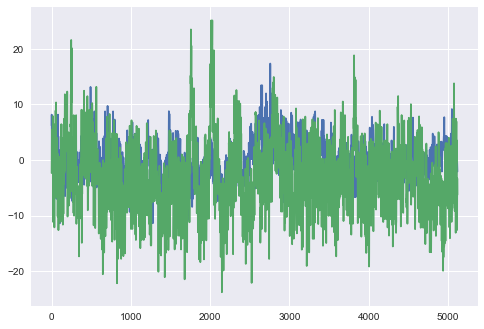

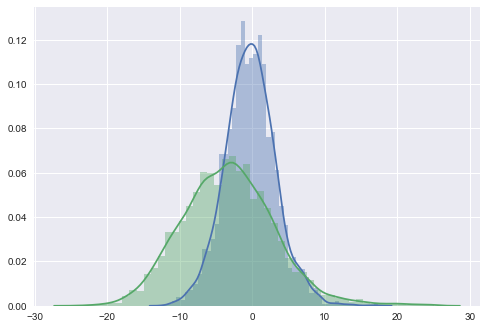

Ttest_relResult(statistic=array([ 30.19974581]), pvalue=array([  1.60455273e-184]))


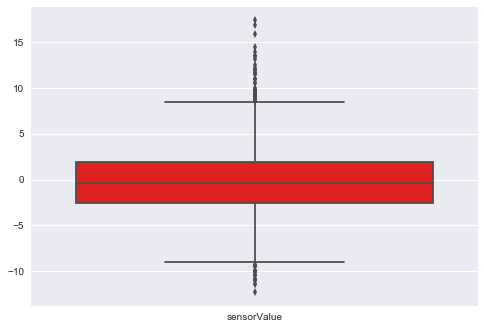

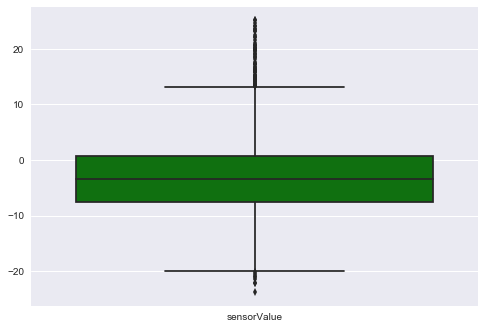

Ttest_1sampResult(statistic=array([-5.30765331]), pvalue=array([  1.15730447e-07]))
Ttest_indResult(statistic=array([ 29.21890427]), pvalue=array([  2.45547540e-180]))
================Sensor Position FC5================================
       sensorValue
count  5120.000000
mean     -1.822221
std       6.715590
min     -32.745000
25%      -6.165000
50%      -1.678000
75%       2.889000
max      23.265000
       sensorValue
count  5120.000000
mean     -4.696025
std       6.325486
min     -22.909000
25%      -9.084000
50%      -4.812000
75%      -0.397000
max      20.386000


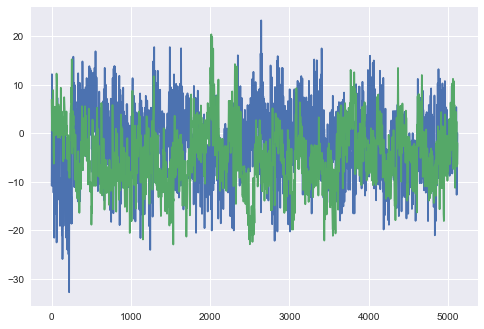

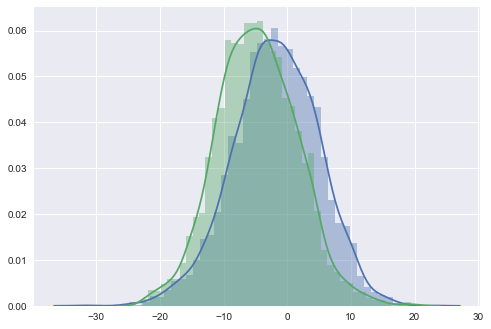

Ttest_relResult(statistic=array([ 21.60260431]), pvalue=array([  4.02816725e-99]))


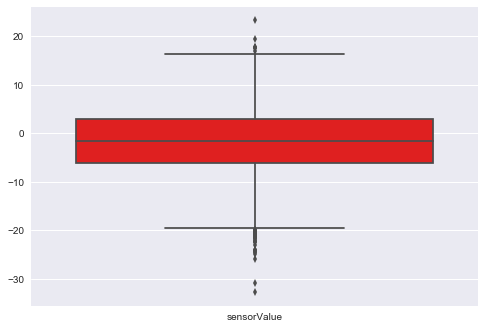

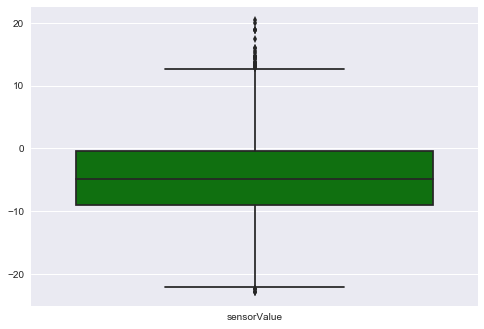

Ttest_1sampResult(statistic=array([-19.41564492]), pvalue=array([  4.40982652e-81]))
Ttest_indResult(statistic=array([ 22.28946001]), pvalue=array([  1.64459877e-107]))
================Sensor Position FC6================================
       sensorValue
count  5120.000000
mean     -1.605738
std       4.174240
min     -13.753000
25%      -4.476000
50%      -1.577000
75%       1.119000
max      16.144000
       sensorValue
count  5120.000000
mean     -5.043214
std       9.594328
min     -36.601000
25%     -11.627000
50%      -5.646000
75%       0.999500
max      47.709000


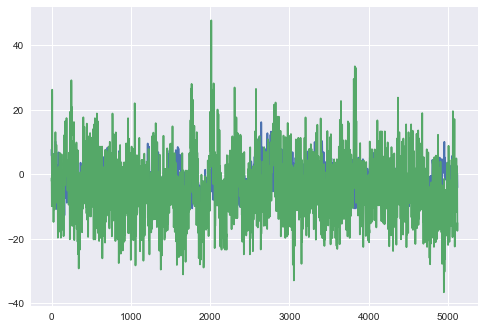

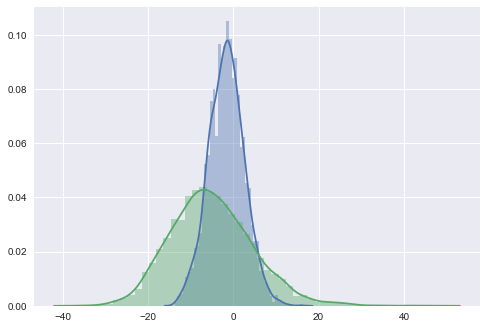

Ttest_relResult(statistic=array([ 23.77554604]), pvalue=array([  1.30595566e-118]))


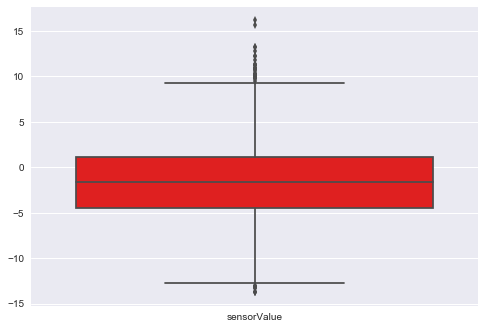

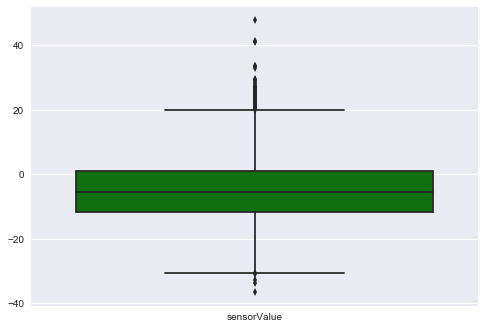

Ttest_1sampResult(statistic=array([-27.5253227]), pvalue=array([  1.15981171e-155]))
Ttest_indResult(statistic=array([ 23.50803314]), pvalue=array([  4.63966880e-119]))
================Sensor Position P5================================
       sensorValue
count  5120.000000
mean     -6.073563
std       5.727058
min     -25.146000
25%      -9.878000
50%      -5.971000
75%      -2.126000
max      13.306000
       sensorValue
count  5120.000000
mean     -4.854133
std       8.162037
min     -39.266000
25%      -9.745000
50%      -4.374000
75%       0.244000
max      21.535000


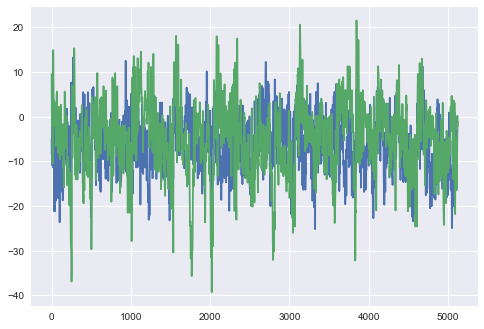

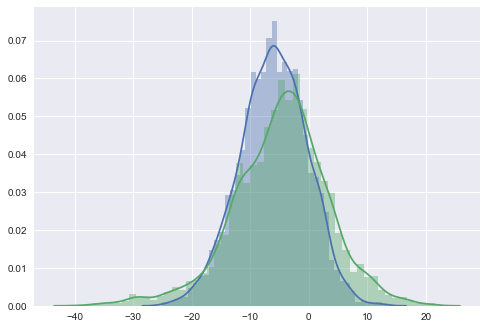

Ttest_relResult(statistic=array([-9.01999145]), pvalue=array([  2.61054754e-19]))


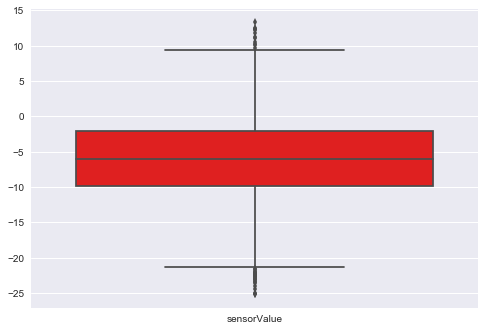

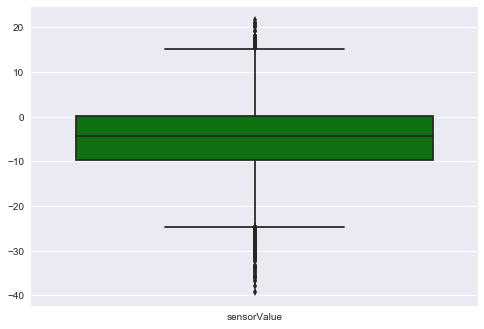

Ttest_1sampResult(statistic=array([-75.88343572]), pvalue=array([ 0.]))
Ttest_indResult(statistic=array([-8.7510337]), pvalue=array([  2.44688629e-18]))
================Sensor Position PO7================================
       sensorValue
count  5120.000000
mean     -8.126003
std      15.294110
min     -91.380000
25%     -17.192000
50%      -6.734000
75%       2.757000
max      33.132000
       sensorValue
count  5120.000000
mean     -7.779347
std      11.420848
min     -57.566000
25%     -14.964000
50%      -7.253000
75%      -0.295000
max      29.877000


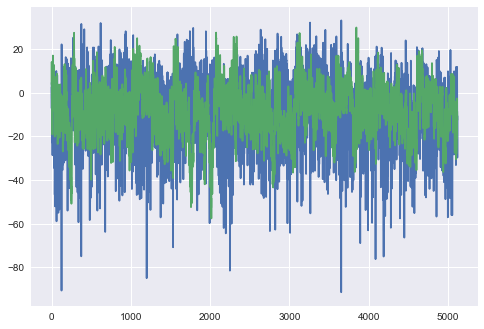

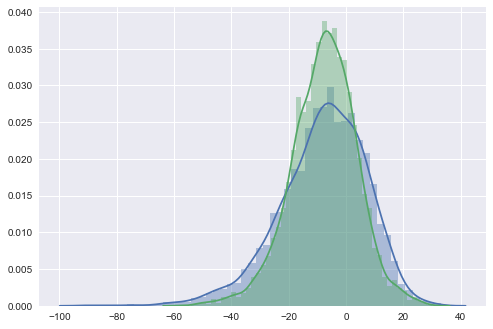

Ttest_relResult(statistic=array([-1.31836345]), pvalue=array([ 0.18744099]))


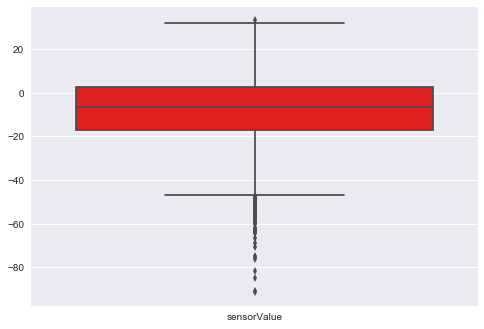

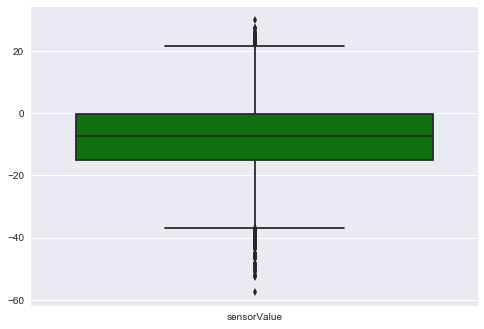

Ttest_1sampResult(statistic=array([-38.01786438]), pvalue=array([  8.53861232e-279]))
Ttest_indResult(statistic=array([-1.29949999]), pvalue=array([ 0.19380166]))
================Sensor Position P8================================
       sensorValue
count  5120.000000
mean     -8.775231
std       6.824427
min     -33.956000
25%     -13.418000
50%      -9.023000
75%      -3.855000
max      12.756000
       sensorValue
count  5120.000000
mean     -8.378799
std       8.956751
min     -46.570000
25%     -13.499000
50%      -7.996000
75%      -2.441000
max      22.868000


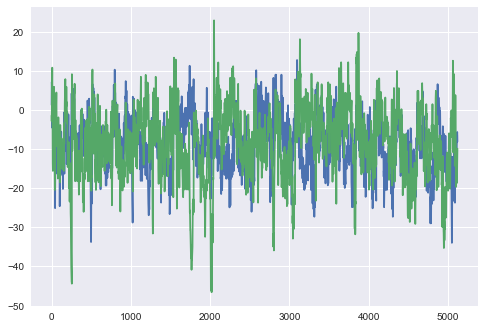

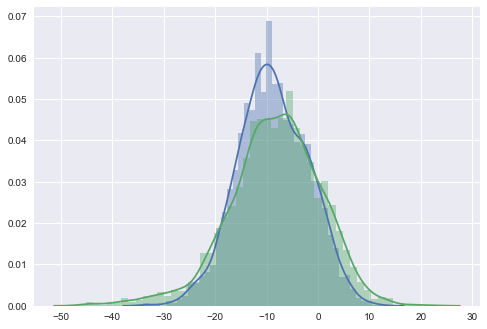

Ttest_relResult(statistic=array([-2.58815503]), pvalue=array([ 0.00967643]))


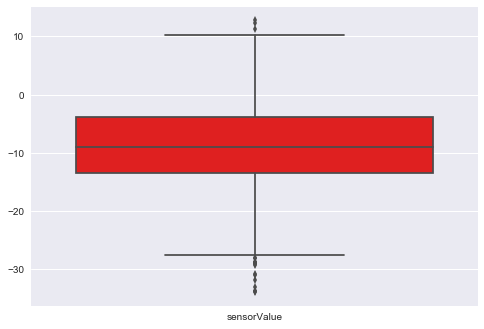

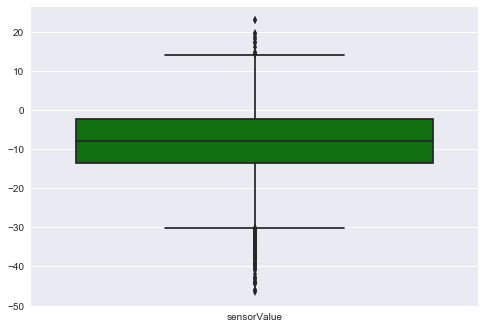

Ttest_1sampResult(statistic=array([-92.0083773]), pvalue=array([ 0.]))
Ttest_indResult(statistic=array([-2.51913017]), pvalue=array([ 0.01177962]))
================Sensor Position PO2================================
       sensorValue
count  5120.000000
mean     -6.031896
std       5.903425
min     -30.080000
25%      -9.532000
50%      -5.656000
75%      -2.218000
max      13.407000
       sensorValue
count  5120.000000
mean     -5.738040
std       8.939684
min     -48.228000
25%     -10.793000
50%      -5.381000
75%      -0.028250
max      24.963000


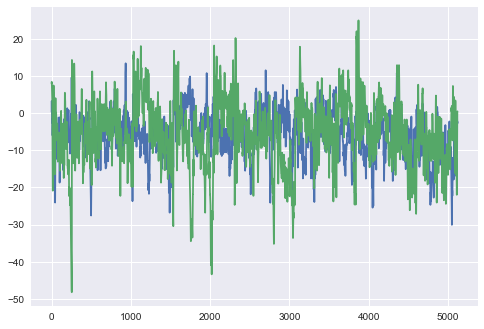

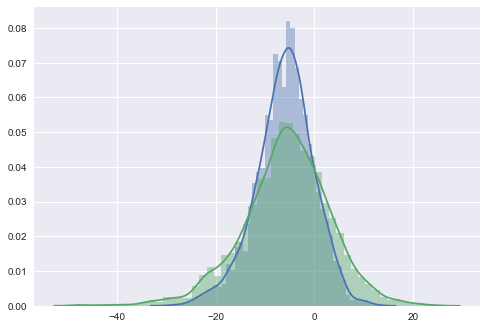

Ttest_relResult(statistic=array([-1.98999738]), pvalue=array([ 0.04664433]))


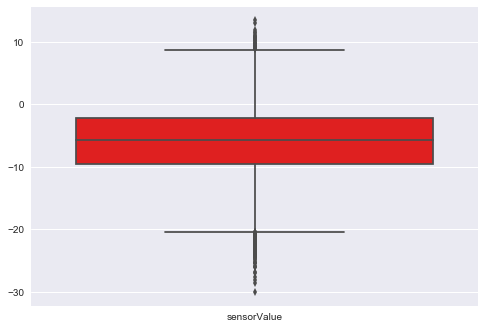

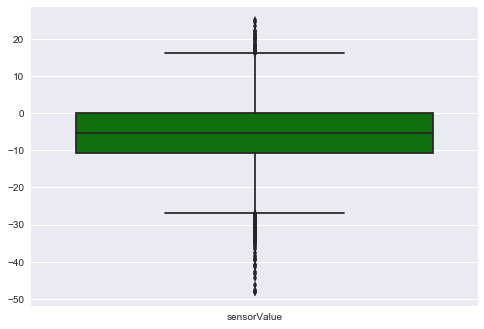

Ttest_1sampResult(statistic=array([-73.11134331]), pvalue=array([ 0.]))
Ttest_indResult(statistic=array([-1.96271686]), pvalue=array([ 0.04970612]))
================Sensor Position TP8================================
       sensorValue
count  5120.000000
mean     -6.776617
std       6.578470
min     -35.055000
25%     -11.271000
50%      -6.816000
75%      -2.279000
max      14.435000
       sensorValue
count  5120.000000
mean     -7.832461
std       8.432154
min     -39.836000
25%     -13.204000
50%      -7.629000
75%      -1.973000
max      21.434000


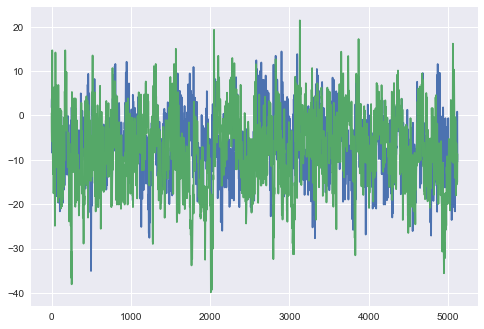

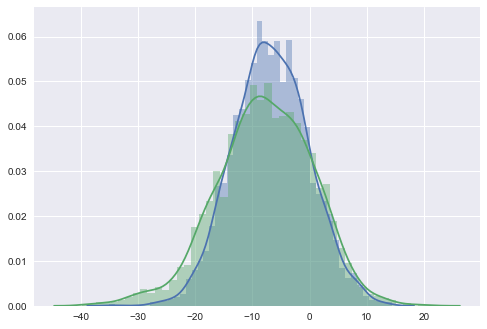

Ttest_relResult(statistic=array([ 7.28680314]), pvalue=array([  3.65773123e-13]))


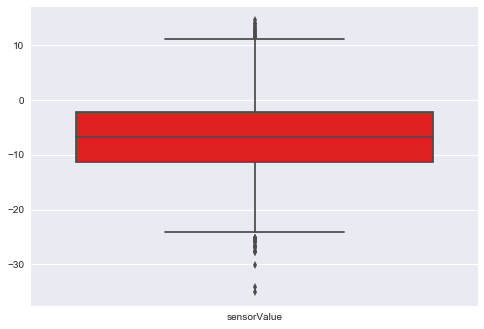

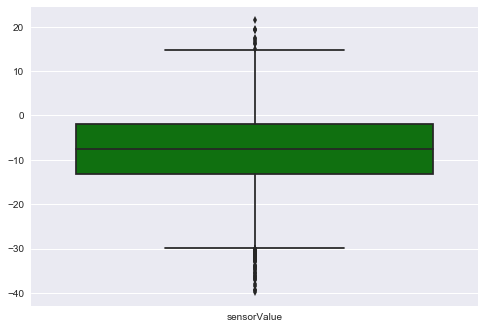

Ttest_1sampResult(statistic=array([-73.70942396]), pvalue=array([ 0.]))
Ttest_indResult(statistic=array([ 7.06421978]), pvalue=array([  1.72028302e-12]))
================Sensor Position PO1================================
       sensorValue
count  5120.000000
mean     -5.803141
std       5.811259
min     -27.751000
25%      -9.237000
50%      -5.646000
75%      -1.862000
max      16.693000
       sensorValue
count  5120.000000
mean     -4.352316
std       9.359872
min     -41.707000
25%      -9.669000
50%      -3.896000
75%       1.322250
max      28.259000


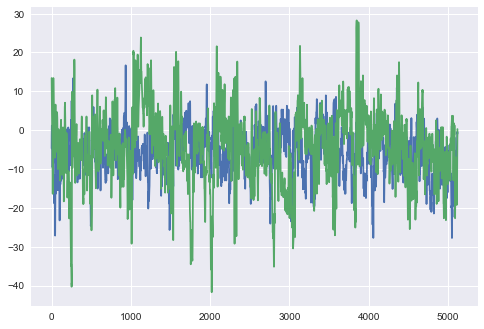

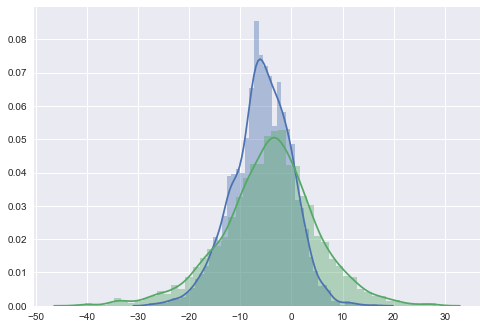

Ttest_relResult(statistic=array([-9.28365966]), pvalue=array([  2.36376336e-20]))


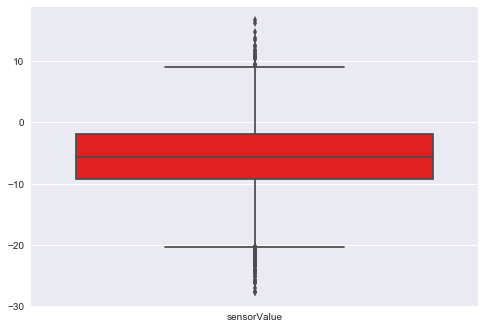

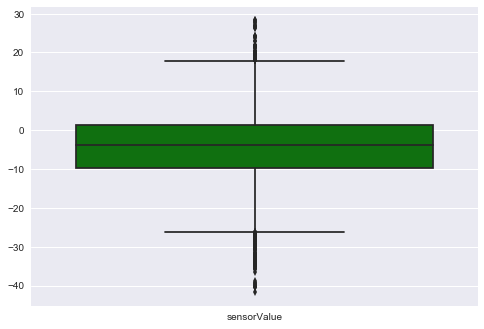

Ttest_1sampResult(statistic=array([-71.45422252]), pvalue=array([ 0.]))
Ttest_indResult(statistic=array([-9.42280625]), pvalue=array([  5.34124148e-21]))
================Sensor Position CZ================================
       sensorValue
count  5120.000000
mean    -14.693239
std      17.998470
min     -92.539000
25%     -23.844000
50%     -11.851000
75%      -1.648000
max      29.205000
       sensorValue
count  5120.000000
mean    -13.774299
std      16.752331
min     -94.655000
25%     -23.214000
50%     -11.754000
75%      -2.093250
max      27.079000


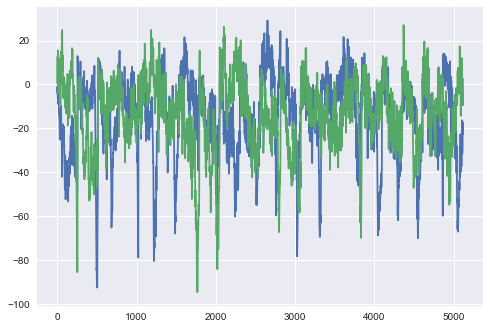

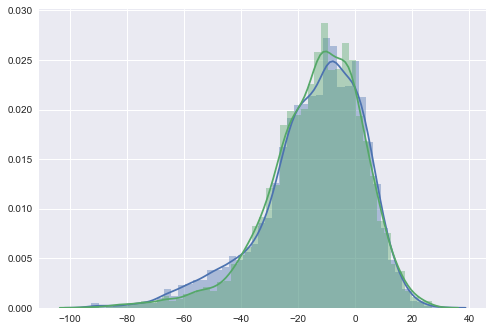

Ttest_relResult(statistic=array([-2.72814965]), pvalue=array([ 0.00639081]))


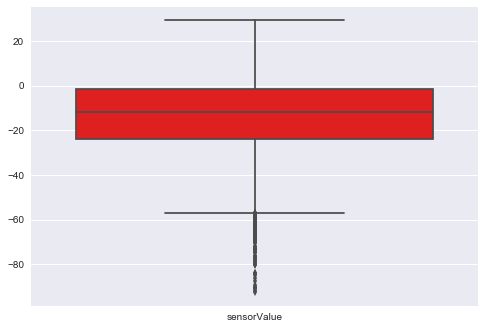

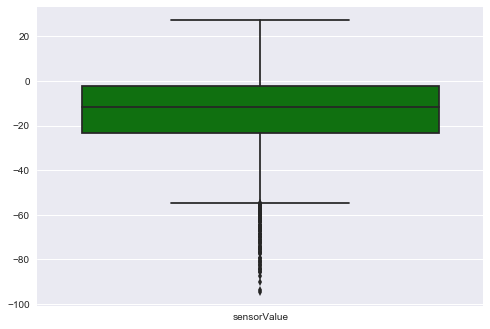

Ttest_1sampResult(statistic=array([-58.41399956]), pvalue=array([ 0.]))
Ttest_indResult(statistic=array([-2.67419632]), pvalue=array([ 0.00750275]))
================Sensor Position T7================================
       sensorValue
count  5120.000000
mean     -5.613713
std       6.470998
min     -26.652000
25%     -10.101000
50%      -5.885000
75%      -1.302000
max      24.689000
       sensorValue
count  5120.000000
mean     -6.525963
std       7.419699
min     -32.318000
25%     -11.566000
50%      -6.460000
75%      -1.597000
max      20.376000


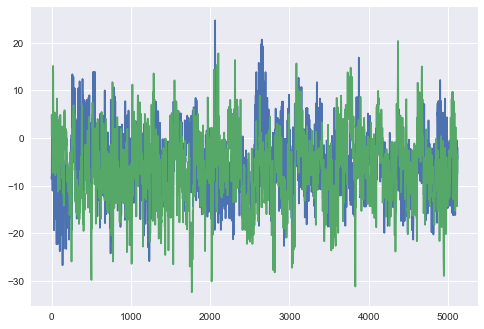

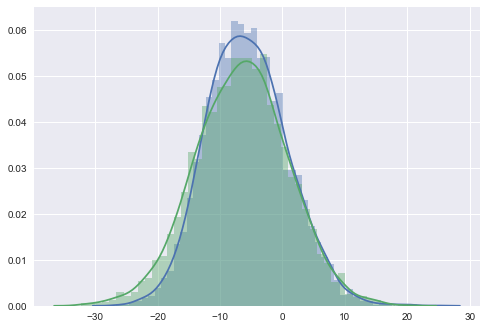

Ttest_relResult(statistic=array([ 6.92191912]), pvalue=array([  5.00386321e-12]))


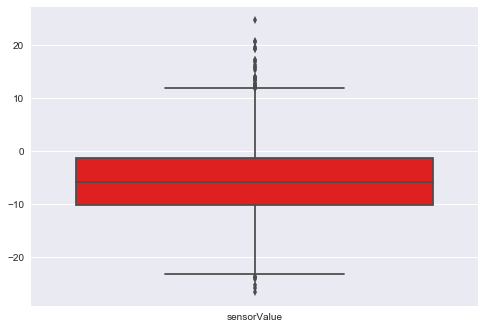

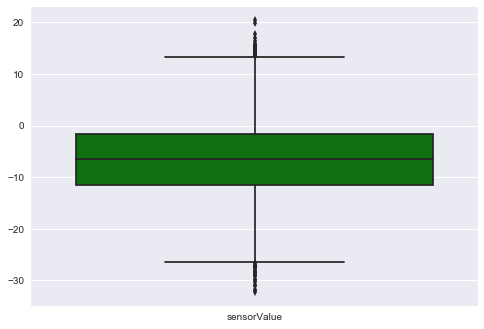

Ttest_1sampResult(statistic=array([-62.07460669]), pvalue=array([ 0.]))
Ttest_indResult(statistic=array([ 6.63023639]), pvalue=array([  3.52043018e-11]))
================Sensor Position AFZ================================
       sensorValue
count  5120.000000
mean      1.692669
std       8.773601
min     -14.760000
25%      -3.652000
50%       0.041000
75%       4.598000
max      62.042000
       sensorValue
count  5120.000000
mean     -4.480257
std      13.735871
min     -27.232000
25%     -11.973000
50%      -6.755000
75%      -0.916000
max      96.914000


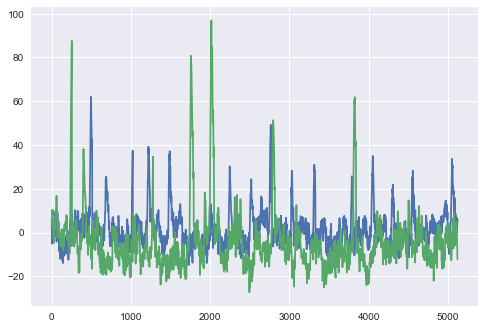

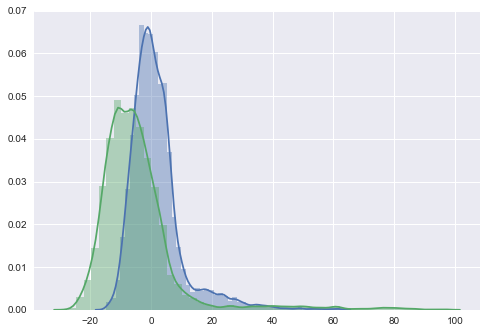

Ttest_relResult(statistic=array([ 26.26872864]), pvalue=array([  8.75702414e-143]))


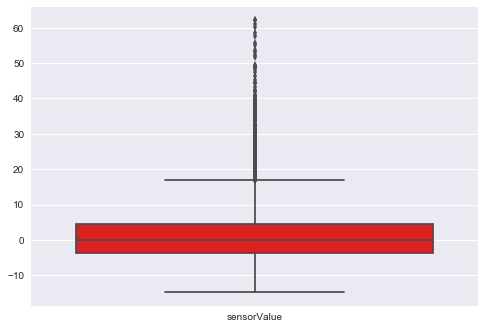

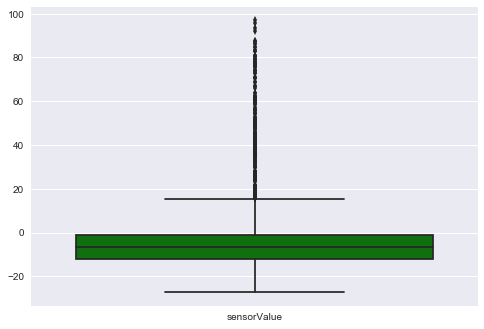

Ttest_1sampResult(statistic=array([ 13.80476644]), pvalue=array([  1.37144599e-42]))
Ttest_indResult(statistic=array([ 27.1001016]), pvalue=array([  2.93390135e-156]))
================Sensor Position PO8================================
       sensorValue
count  5120.000000
mean     -8.418078
std      10.160450
min     -91.858000
25%     -14.333000
50%      -8.087000
75%      -1.536000
max      31.555000
       sensorValue
count  5120.000000
mean     -9.081013
std      10.781162
min     -62.215000
25%     -15.554000
50%      -8.484000
75%      -1.811000
max      23.285000


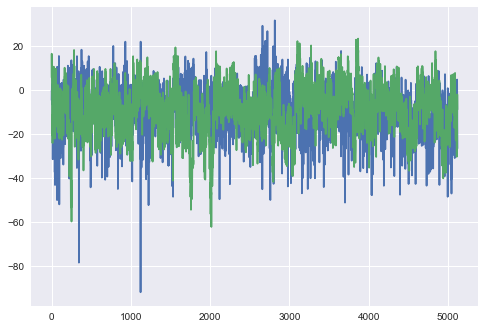

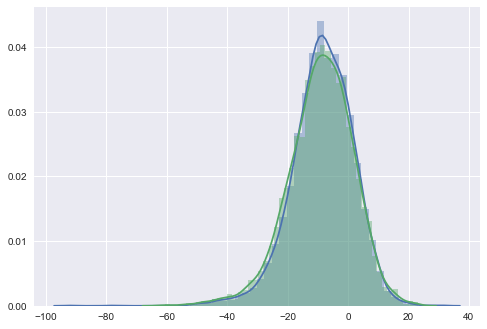

Ttest_relResult(statistic=array([ 3.23518243]), pvalue=array([ 0.00122338]))


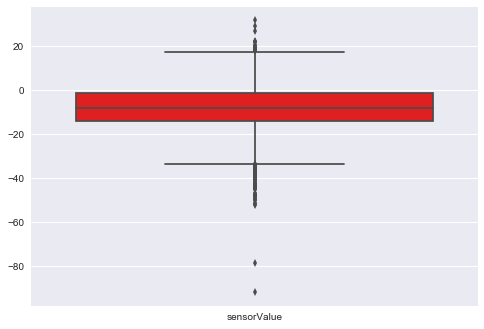

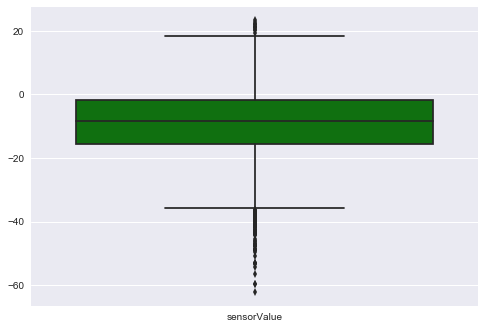

Ttest_1sampResult(statistic=array([-59.28365359]), pvalue=array([ 0.]))
Ttest_indResult(statistic=array([ 3.20199093]), pvalue=array([ 0.00136899]))
================Sensor Position X================================
       sensorValue
count  5120.000000
mean      1.536599
std      26.930948
min     -42.053000
25%     -12.787000
50%      -4.084500
75%       4.232000
max     183.777000
       sensorValue
count  5120.000000
mean      0.646338
std      36.915941
min     -44.657000
25%     -15.127000
50%      -7.105500
75%       3.784000
max     278.687000


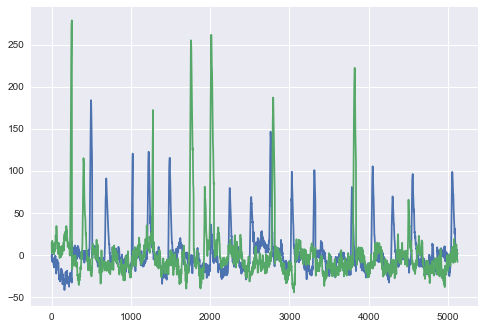

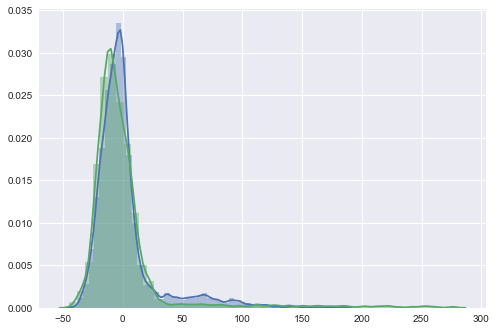

Ttest_relResult(statistic=array([ 1.37218529]), pvalue=array([ 0.17006589]))


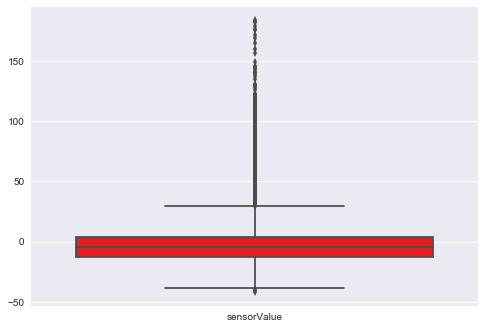

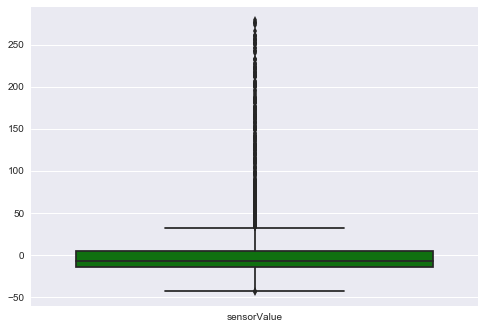

Ttest_1sampResult(statistic=array([ 4.08266633]), pvalue=array([  4.52007477e-05]))
Ttest_indResult(statistic=array([ 1.39405762]), pvalue=array([ 0.16333046]))
================Sensor Position FPZ================================
       sensorValue
count  5120.000000
mean      1.270996
std      15.886915
min     -26.998000
25%      -7.548000
50%      -1.668000
75%       4.517000
max     114.288000
       sensorValue
count  5120.000000
mean     -2.719194
std      22.095409
min     -35.207000
25%     -13.112000
50%      -7.172000
75%       0.275000
max     161.021000


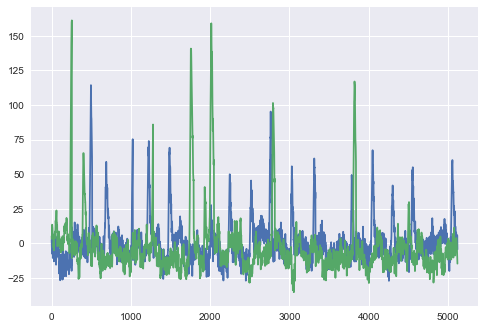

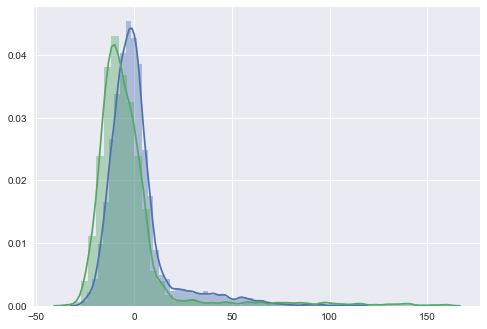

Ttest_relResult(statistic=array([ 10.19095024]), pvalue=array([  3.69636651e-24]))


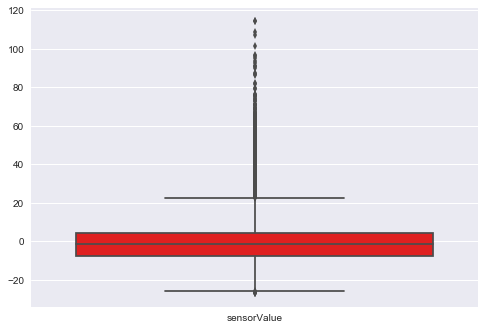

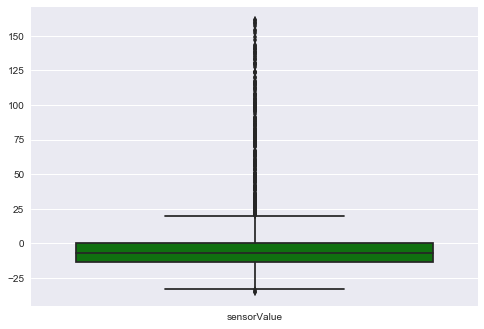

Ttest_1sampResult(statistic=array([ 5.72452719]), pvalue=array([  1.09627799e-08]))
Ttest_indResult(statistic=array([ 10.49147012]), pvalue=array([  1.27504713e-25]))
================Sensor Position F1================================
       sensorValue
count  5120.000000
mean      0.563787
std       5.554081
min     -13.814000
25%      -3.072000
50%      -0.112000
75%       3.306000
max      37.109000
       sensorValue
count  5120.000000
mean     -3.678203
std       8.620107
min     -28.320000
25%      -9.003000
50%      -4.628000
75%       0.132000
max      54.087000


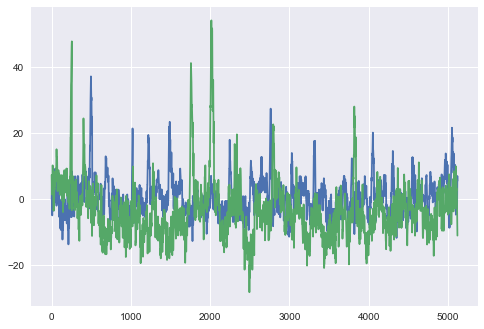

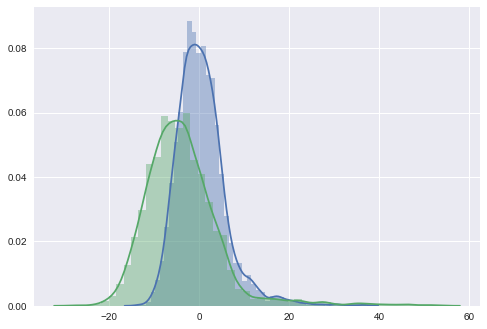

Ttest_relResult(statistic=array([ 29.1717667]), pvalue=array([  3.34483756e-173]))


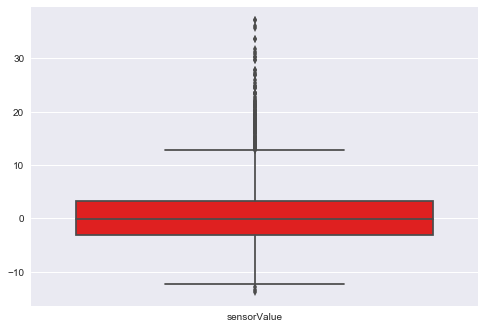

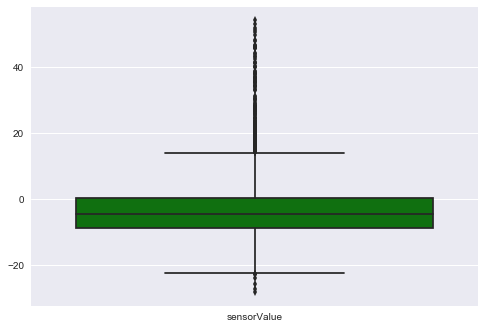

Ttest_1sampResult(statistic=array([ 7.26335826]), pvalue=array([  4.34375450e-13]))
Ttest_indResult(statistic=array([ 29.5999846]), pvalue=array([  7.88567888e-185]))
================Sensor Position F2================================
       sensorValue
count  5120.000000
mean      1.249284
std       5.421551
min     -12.227000
25%      -2.228000
50%       0.529000
75%       3.672000
max      34.047000
       sensorValue
count  5120.000000
mean     -3.686844
std       9.044833
min     -22.563000
25%      -9.349000
50%      -5.015000
75%      -0.381500
max      58.400000


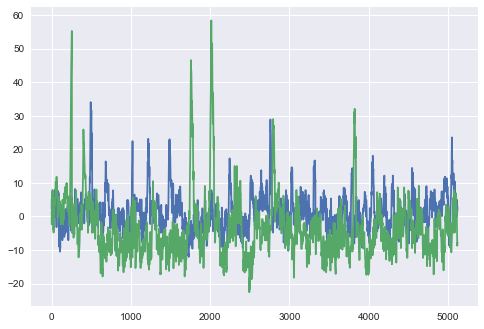

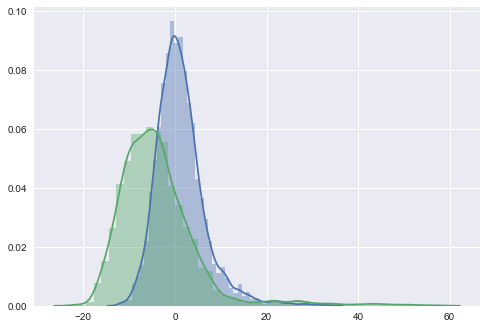

Ttest_relResult(statistic=array([ 32.71873294]), pvalue=array([  2.19830145e-213]))


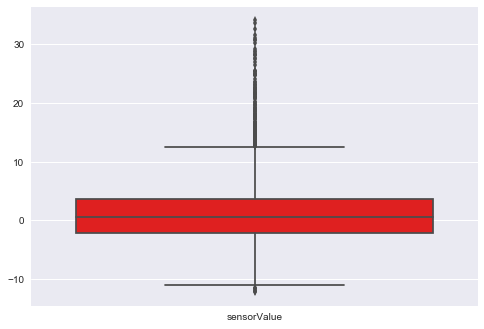

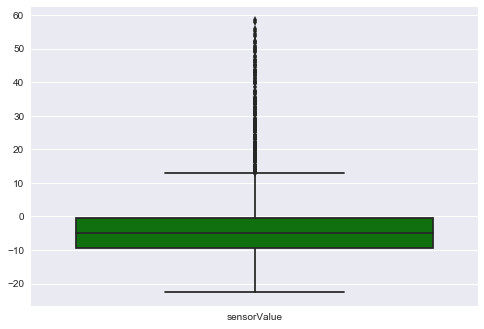

Ttest_1sampResult(statistic=array([ 16.48817727]), pvalue=array([  1.49607624e-59]))
Ttest_indResult(statistic=array([ 33.49381656]), pvalue=array([  1.74120206e-233]))
================Sensor Position F3================================
       sensorValue
count  5120.000000
mean     -0.196997
std       5.792732
min     -19.480000
25%      -4.059000
50%      -0.783000
75%       2.833250
max      37.272000
       sensorValue
count  5120.000000
mean     -3.759540
std       9.132861
min     -34.200000
25%      -9.389000
50%      -4.425000
75%       0.661000
max      52.094000


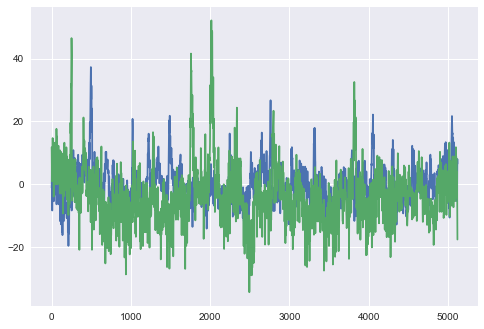

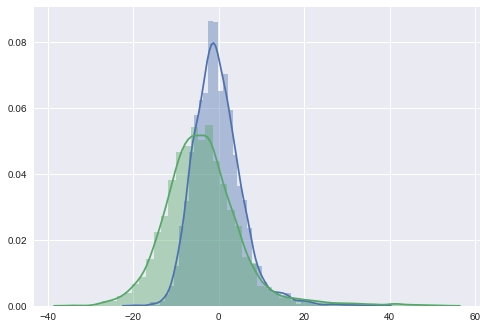

Ttest_relResult(statistic=array([ 23.3523825]), pvalue=array([  1.07070598e-114]))


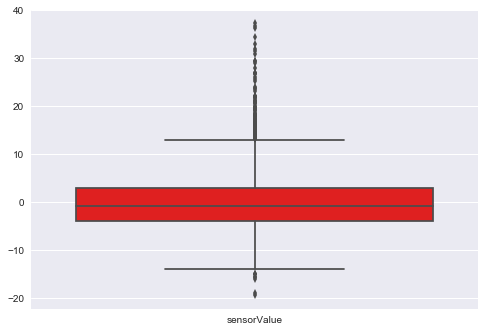

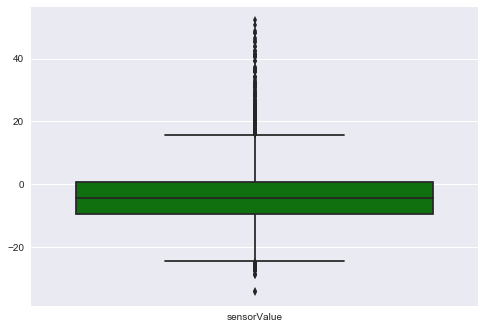

Ttest_1sampResult(statistic=array([-2.43338527]), pvalue=array([ 0.01499237]))
Ttest_indResult(statistic=array([ 23.57042428]), pvalue=array([  1.14901219e-119]))
================Sensor Position F4================================
       sensorValue
count  5120.000000
mean      0.533174
std       5.855134
min     -16.205000
25%      -3.204000
50%       0.173000
75%       3.560000
max      33.478000
       sensorValue
count  5120.000000
mean     -3.697843
std       9.317387
min     -21.729000
25%      -9.430000
50%      -5.025000
75%      -0.407000
max      60.038000


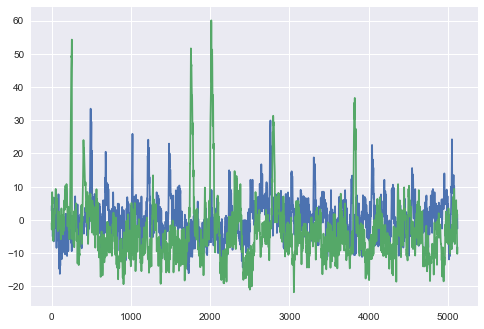

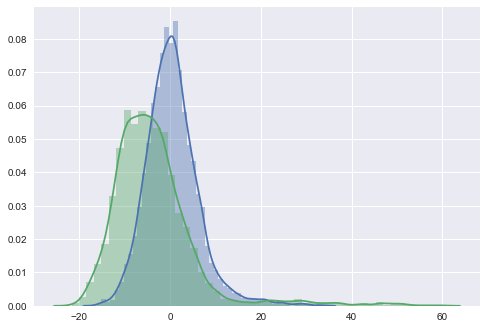

Ttest_relResult(statistic=array([ 26.81820072]), pvalue=array([  2.32663795e-148]))


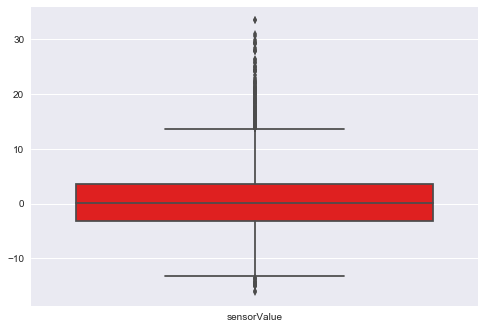

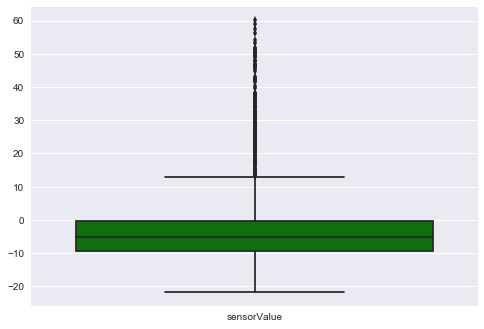

Ttest_1sampResult(statistic=array([ 6.51579057]), pvalue=array([  7.92466841e-11]))
Ttest_indResult(statistic=array([ 27.51150257]), pvalue=array([  8.20084640e-161]))
================Sensor Position F5================================
       sensorValue
count  5120.000000
mean     -1.414105
std       6.629200
min     -27.507000
25%      -5.686000
50%      -1.770000
75%       2.258000
max      35.950000
       sensorValue
count  5120.000000
mean     -5.003804
std       9.375028
min     -29.165000
25%     -10.905000
50%      -6.175000
75%      -0.061000
max      57.343000


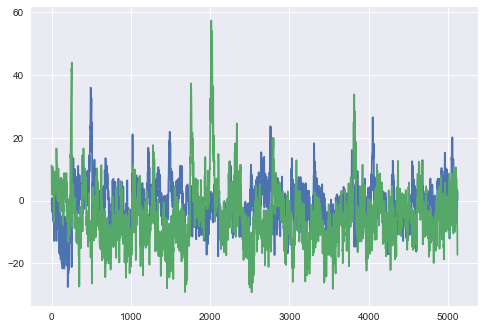

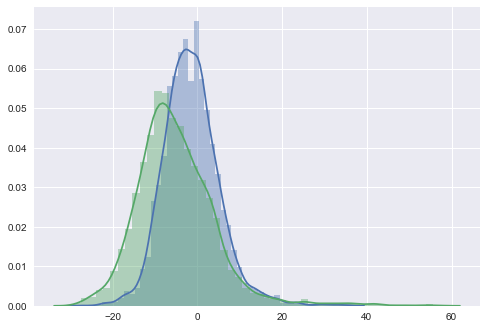

Ttest_relResult(statistic=array([ 21.56193017]), pvalue=array([  9.02190563e-99]))


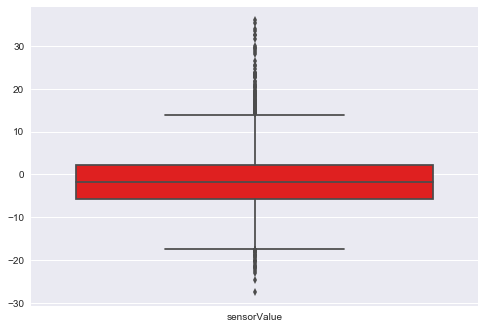

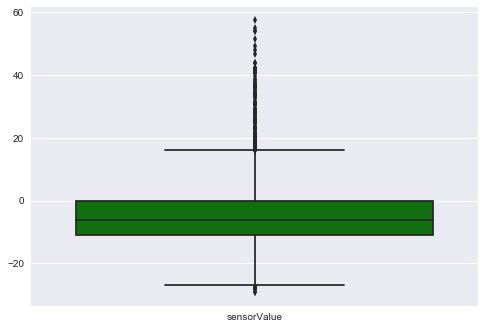

Ttest_1sampResult(statistic=array([-15.26354605]), pvalue=array([  1.79255030e-51]))
Ttest_indResult(statistic=array([ 22.37039694]), pvalue=array([  2.92489521e-108]))
================Sensor Position F6================================
       sensorValue
count  5120.000000
mean     -0.642327
std       6.971346
min     -21.688000
25%      -5.086000
50%      -1.017000
75%       3.276000
max      35.441000
       sensorValue
count  5120.000000
mean     -4.813964
std      11.384516
min     -35.787000
25%     -11.505000
50%      -6.368000
75%      -0.651000
max      72.469000


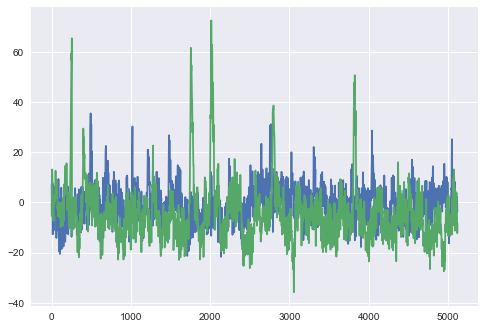

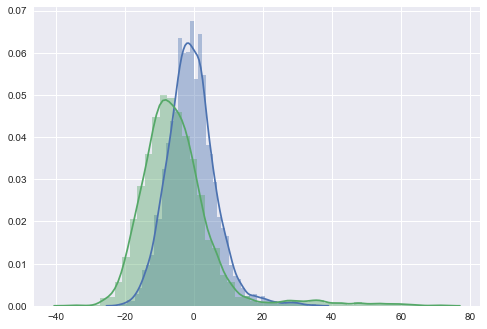

Ttest_relResult(statistic=array([ 22.04695836]), pvalue=array([  5.54456465e-103]))


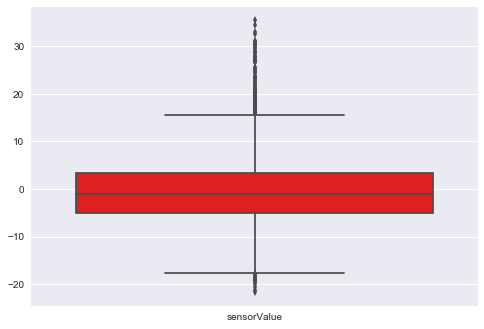

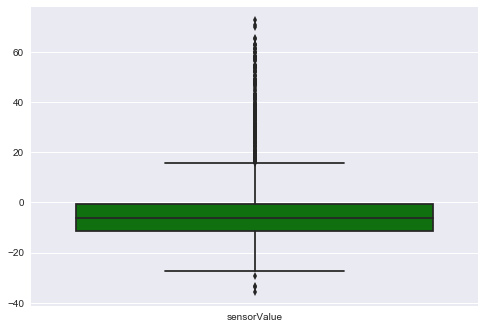

Ttest_1sampResult(statistic=array([-6.59287334]), pvalue=array([  4.74831112e-11]))
Ttest_indResult(statistic=array([ 22.36038464]), pvalue=array([  3.62256190e-108]))
================Sensor Position F7================================
       sensorValue
count  5120.000000
mean     -2.663302
std       8.239311
min     -29.165000
25%      -8.108000
50%      -3.103000
75%       2.092750
max      42.745000
       sensorValue
count  5120.000000
mean     -6.310687
std      11.452345
min     -39.419000
25%     -13.814000
50%      -7.324000
75%      -0.233750
max      62.805000


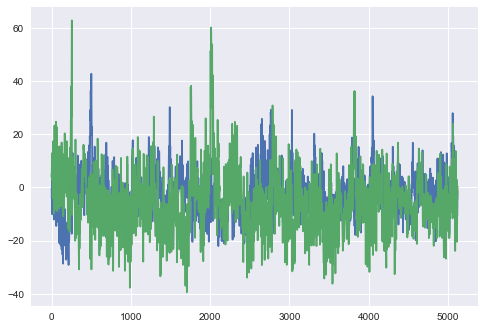

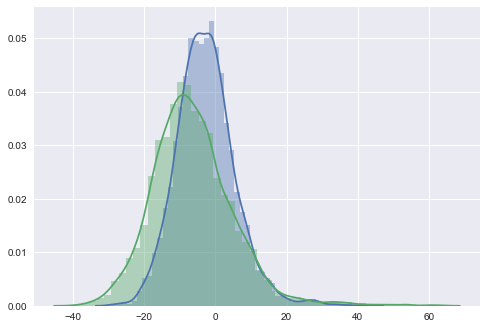

Ttest_relResult(statistic=array([ 18.01372265]), pvalue=array([  2.18038919e-70]))


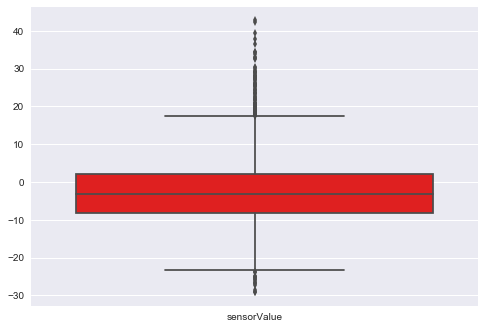

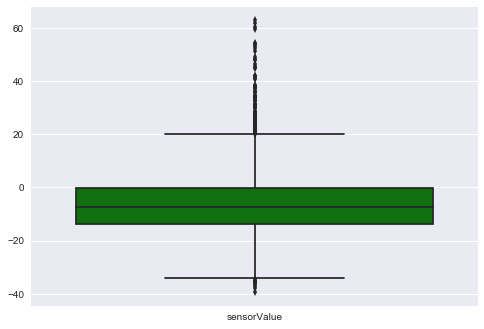

Ttest_1sampResult(statistic=array([-23.1294039]), pvalue=array([  1.17278917e-112]))
Ttest_indResult(statistic=array([ 18.49880787]), pvalue=array([  3.51961479e-75]))
================Sensor Position F8================================
       sensorValue
count  5120.000000
mean     -2.119312
std      10.990393
min     -40.181000
25%      -9.623000
50%      -2.319000
75%       4.641500
max      50.415000
       sensorValue
count  5120.000000
mean     -5.514238
std      13.315634
min     -45.013000
25%     -13.265000
50%      -6.978000
75%      -0.203000
max      79.844000


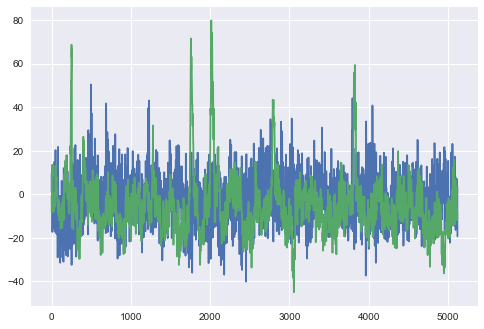

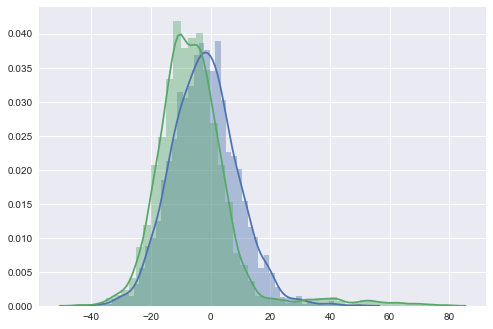

Ttest_relResult(statistic=array([ 13.95806707]), pvalue=array([  1.74558684e-43]))


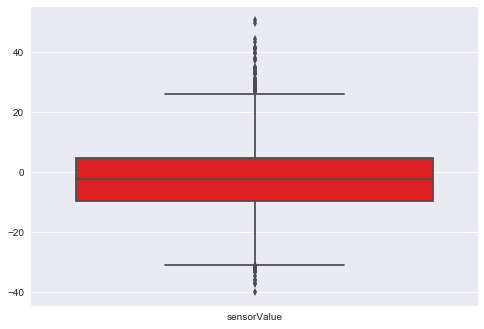

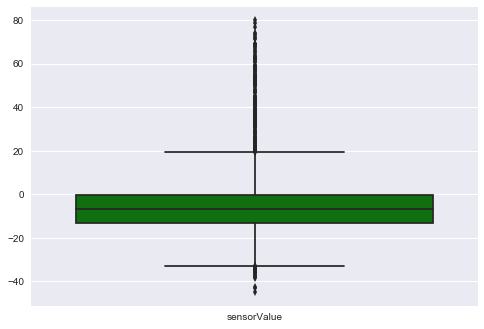

Ttest_1sampResult(statistic=array([-13.79801464]), pvalue=array([  1.50106311e-42]))
Ttest_indResult(statistic=array([ 14.06980422]), pvalue=array([  1.51218174e-44]))
================Sensor Position AF1================================
       sensorValue
count  5120.000000
mean      1.137925
std       9.715142
min     -18.972000
25%      -4.873000
50%      -0.102000
75%       4.415000
max      68.258000
       sensorValue
count  5120.000000
mean     -3.926596
std      13.510127
min     -29.775000
25%     -11.241000
50%      -6.327000
75%      -0.142000
max      94.198000


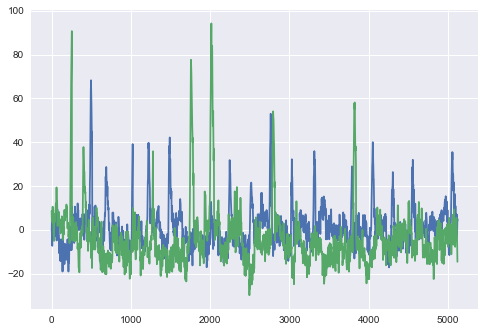

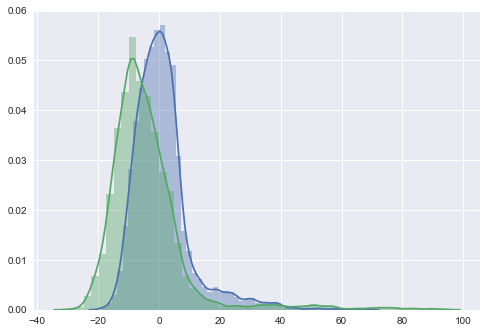

Ttest_relResult(statistic=array([ 20.74809447]), pvalue=array([  7.02080932e-92]))


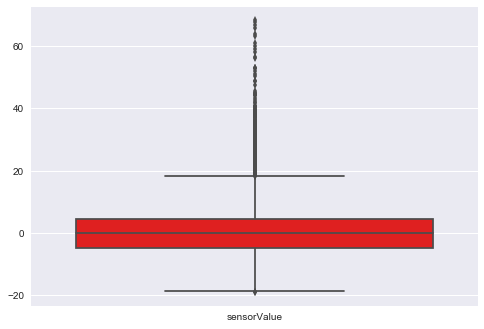

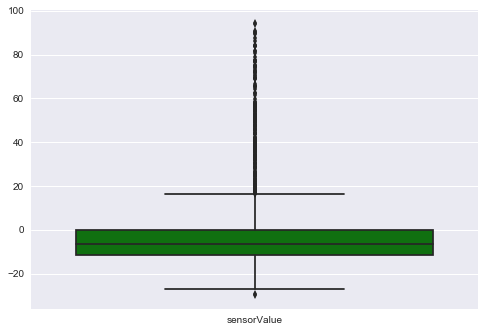

Ttest_1sampResult(statistic=array([ 8.3810687]), pvalue=array([  6.70473608e-17]))
Ttest_indResult(statistic=array([ 21.77739711]), pvalue=array([  8.01175210e-103]))
================Sensor Position AF2================================
       sensorValue
count  5120.000000
mean      1.033722
std       8.990897
min     -20.711000
25%      -4.405000
50%      -0.102000
75%       4.415000
max      58.614000
       sensorValue
count  5120.000000
mean     -3.481163
std      14.602244
min     -27.049000
25%     -11.322000
50%      -6.205000
75%      -0.129500
max     101.410000


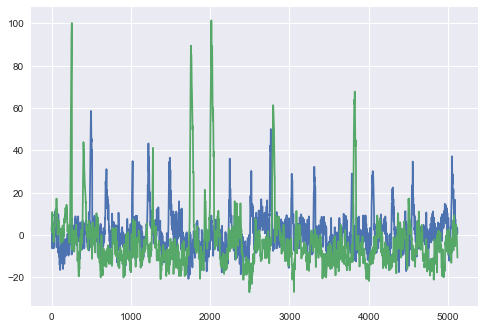

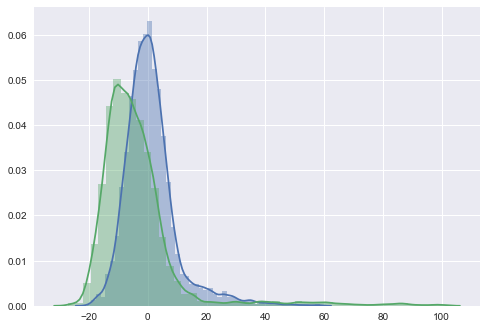

Ttest_relResult(statistic=array([ 18.22883975]), pvalue=array([  5.53112654e-72]))


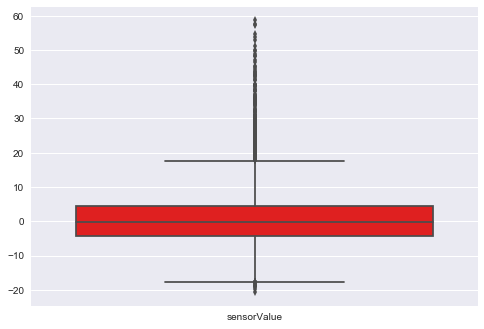

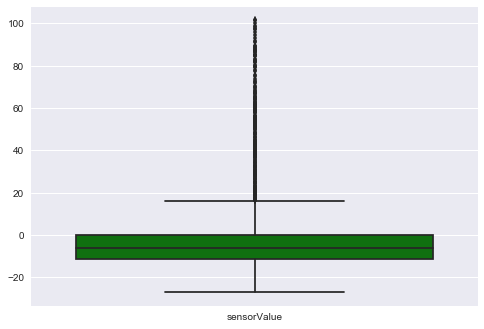

Ttest_1sampResult(statistic=array([ 8.22689458]), pvalue=array([  2.41400460e-16]))
Ttest_indResult(statistic=array([ 18.83920117]), pvalue=array([  7.41127719e-78]))
================Sensor Position T8================================
       sensorValue
count  5120.000000
mean     -4.799931
std       8.591398
min     -30.752000
25%     -10.579000
50%      -4.974000
75%       0.658750
max      29.205000
       sensorValue
count  5120.000000
mean     -7.066661
std       8.892190
min     -38.127000
25%     -13.051000
50%      -7.080000
75%      -0.966000
max      22.705000


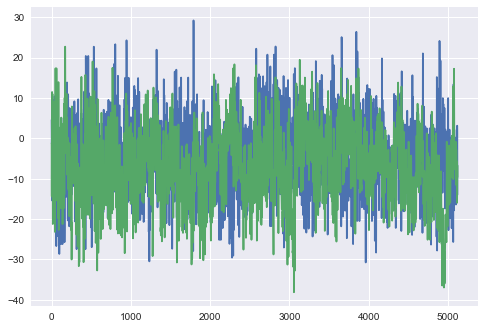

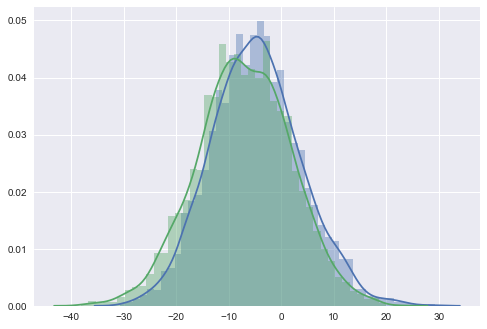

Ttest_relResult(statistic=array([ 13.22538309]), pvalue=array([  2.74441321e-39]))


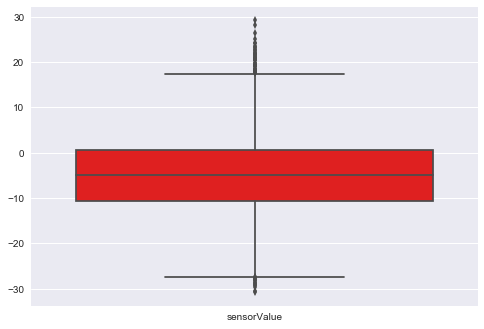

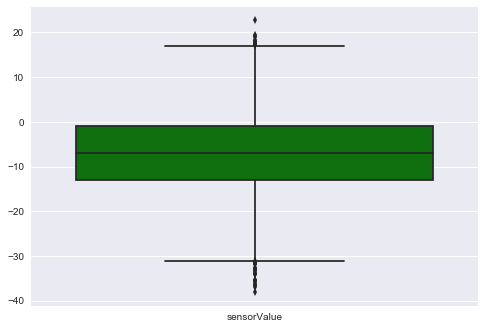

Ttest_1sampResult(statistic=array([-39.97662866]), pvalue=array([  2.19393615e-304]))
Ttest_indResult(statistic=array([ 13.11761587]), pvalue=array([  5.38027289e-39]))
================Sensor Position CP1================================
       sensorValue
count  5120.000000
mean     -1.830062
std       2.424460
min     -13.000000
25%      -3.235000
50%      -1.628000
75%      -0.275000
max       5.809000
       sensorValue
count  5120.000000
mean     -0.432715
std       4.417852
min     -19.643000
25%      -3.352000
50%      -0.213500
75%       2.513000
max      12.115000


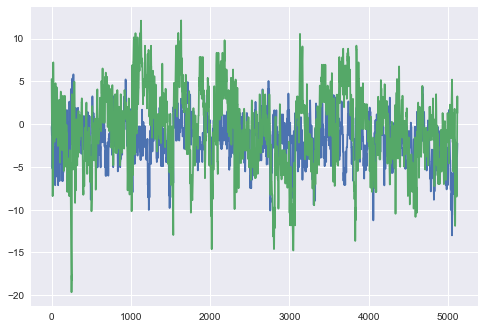

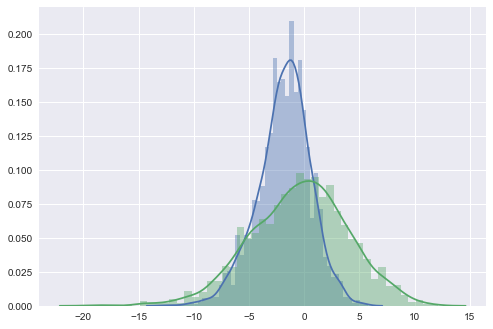

Ttest_relResult(statistic=array([-20.72594542]), pvalue=array([  1.07356518e-91]))


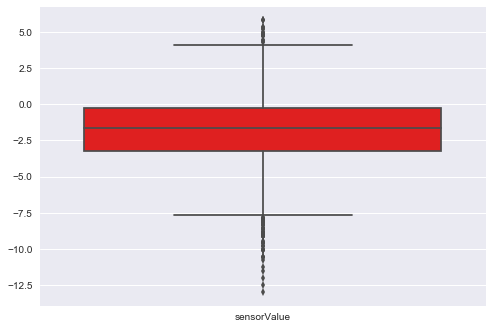

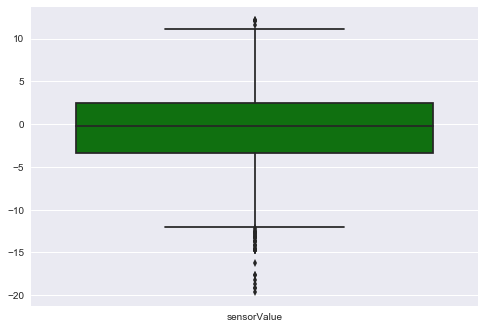

Ttest_1sampResult(statistic=array([-54.01143429]), pvalue=array([ 0.]))
Ttest_indResult(statistic=array([-19.84090347]), pvalue=array([  5.38842621e-86]))
================Sensor Position CP2================================
       sensorValue
count  5120.000000
mean     -1.065968
std       2.519429
min     -12.197000
25%      -2.604000
50%      -1.017000
75%       0.661000
max       6.521000
       sensorValue
count  5120.000000
mean     -0.765573
std       3.928988
min     -19.073000
25%      -3.347000
50%      -0.712000
75%       1.923000
max      10.569000


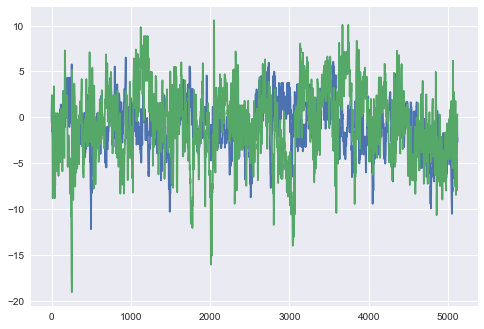

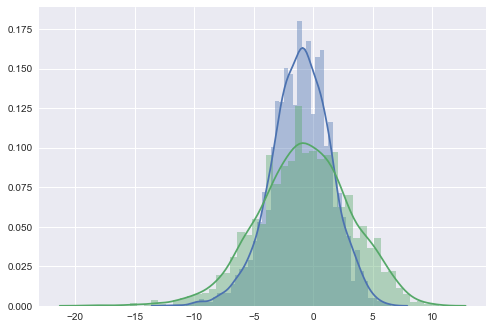

Ttest_relResult(statistic=array([-4.64165371]), pvalue=array([  3.54264860e-06]))


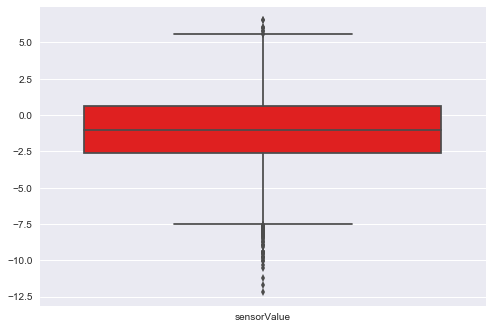

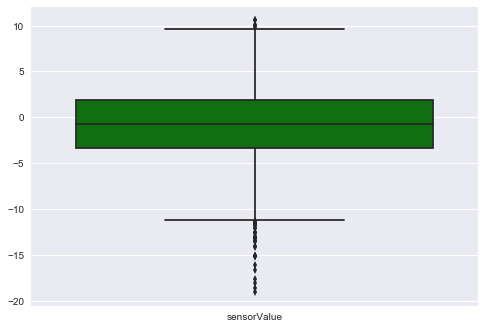

Ttest_1sampResult(statistic=array([-30.27449994]), pvalue=array([  2.35260192e-185]))
Ttest_indResult(statistic=array([-4.60526529]), pvalue=array([  4.16907394e-06]))
================Sensor Position CP3================================
       sensorValue
count  5120.000000
mean     -2.893849
std       3.454068
min     -15.076000
25%      -5.198000
50%      -2.869000
75%      -0.539000
max       9.277000
       sensorValue
count  5120.000000
mean     -2.200065
std       4.998566
min     -23.539000
25%      -5.168000
50%      -1.872000
75%       1.119000
max      12.166000


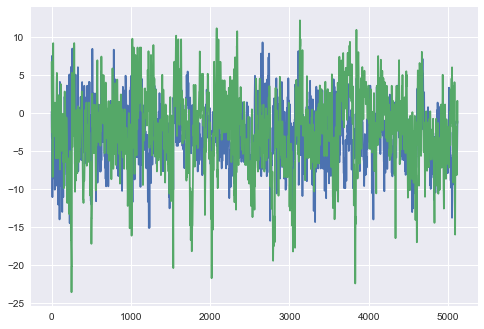

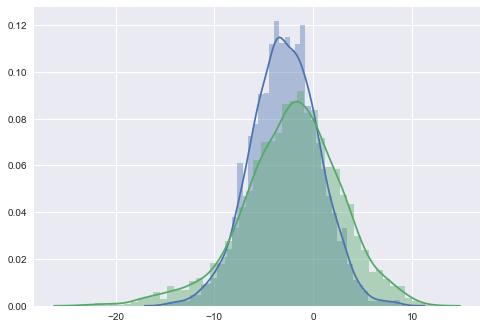

Ttest_relResult(statistic=array([-8.45394553]), pvalue=array([  3.63074240e-17]))


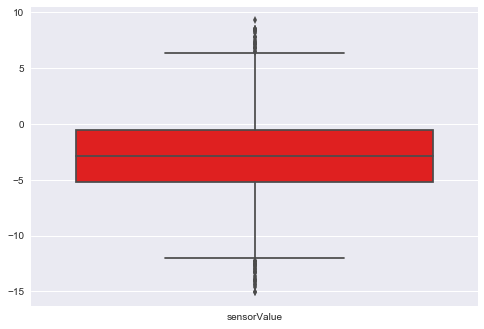

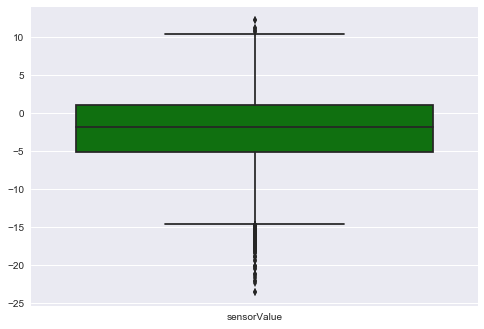

Ttest_1sampResult(statistic=array([-59.94872545]), pvalue=array([ 0.]))
Ttest_indResult(statistic=array([-8.1705321]), pvalue=array([  3.43275833e-16]))
================Sensor Position CP4================================
       sensorValue
count  5120.000000
mean     -2.760496
std       3.363847
min     -19.226000
25%      -4.852000
50%      -2.594000
75%      -0.509000
max       9.583000
       sensorValue
count  5120.000000
mean     -2.658815
std       5.482587
min     -24.821000
25%      -6.154000
50%      -2.502000
75%       1.292000
max      17.985000


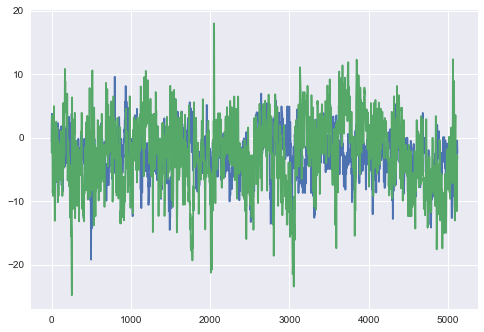

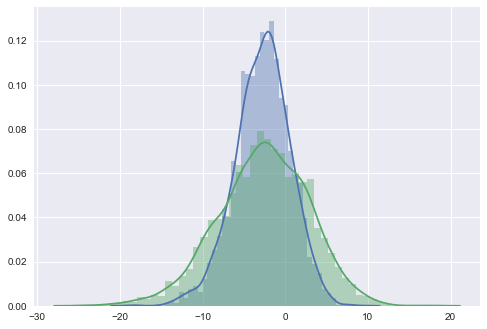

Ttest_relResult(statistic=array([-1.14662982]), pvalue=array([ 0.25158824]))


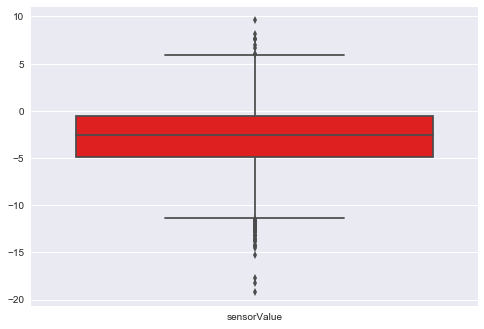

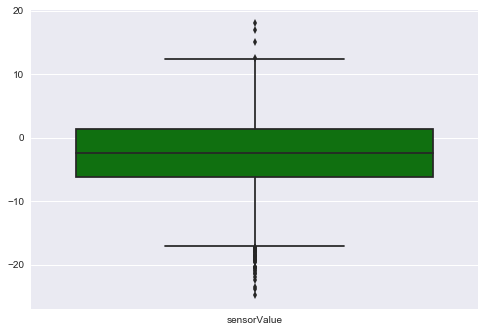

Ttest_1sampResult(statistic=array([-58.71997775]), pvalue=array([ 0.]))
Ttest_indResult(statistic=array([-1.13111932]), pvalue=array([ 0.25803137]))
================Sensor Position CP5================================
       sensorValue
count  5120.000000
mean     -5.137028
std       7.699371
min     -42.226000
25%      -9.949000
50%      -5.117000
75%      -0.427000
max      28.982000
       sensorValue
count  5120.000000
mean     -4.284662
std       6.379943
min     -28.910000
25%      -8.138000
50%      -4.120000
75%      -0.117000
max      16.856000


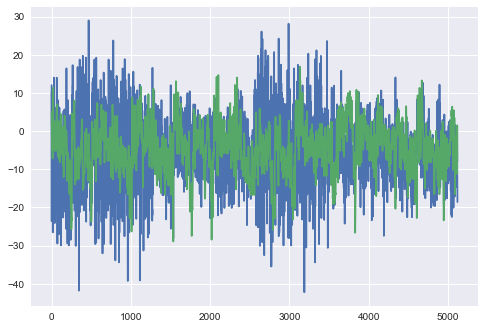

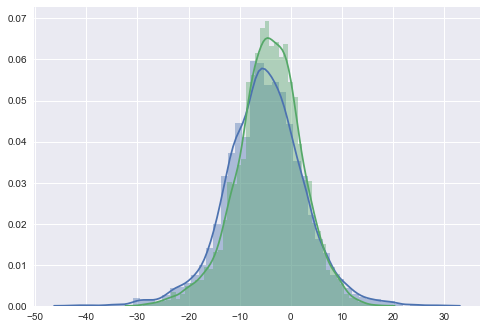

Ttest_relResult(statistic=array([-6.3542085]), pvalue=array([  2.27653152e-10]))


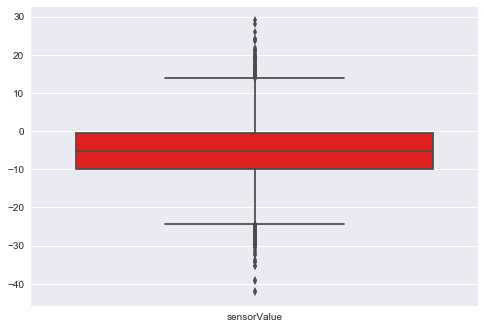

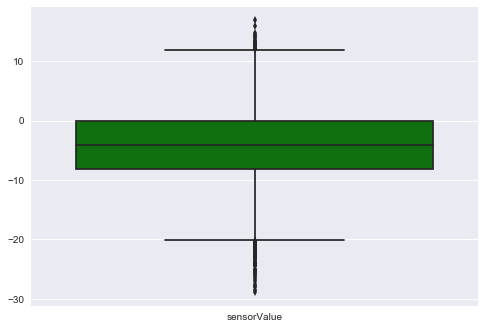

Ttest_1sampResult(statistic=array([-47.74101749]), pvalue=array([ 0.]))
Ttest_indResult(statistic=array([-6.09952302]), pvalue=array([  1.10231205e-09]))
================Sensor Position CP6================================
       sensorValue
count  5120.000000
mean     -4.167717
std       5.749508
min     -23.356000
25%      -7.996000
50%      -4.283000
75%      -0.407000
max      21.566000
       sensorValue
count  5120.000000
mean     -5.151178
std       6.629391
min     -33.020000
25%      -9.572000
50%      -5.015000
75%      -0.458000
max      21.240000


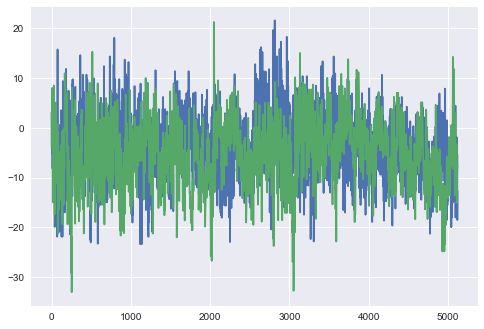

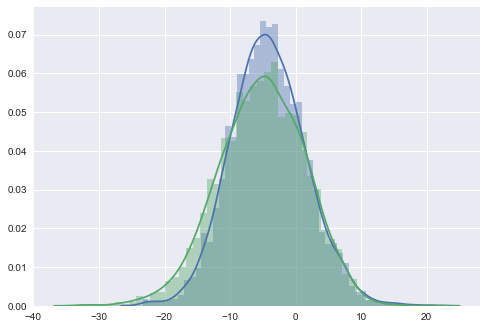

Ttest_relResult(statistic=array([ 8.17098543]), pvalue=array([  3.82012304e-16]))


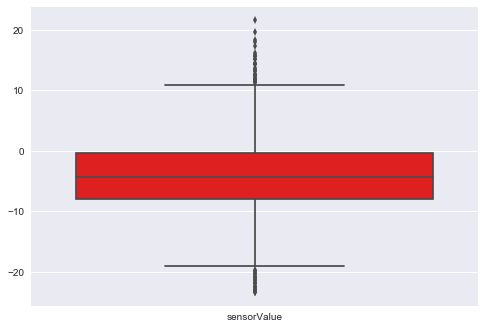

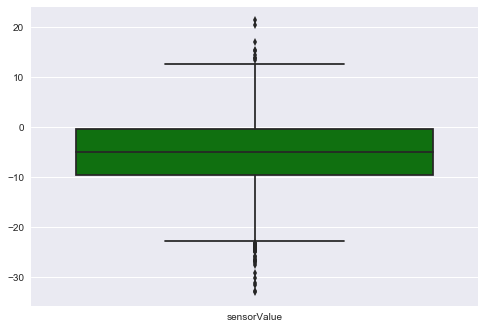

Ttest_1sampResult(statistic=array([-51.86836428]), pvalue=array([ 0.]))
Ttest_indResult(statistic=array([ 8.01919113]), pvalue=array([  1.18071194e-15]))


In [35]:
# creating two groups
sp=df[['trial','channel','sensorValue']]
sp=sp.astype(float)
sns.pairplot(sp)
listedtrials=df.groupby([df['sensorPosition']])['sensorValue'].first()
#    print listedtrials

listedtrials=listedtrials.reset_index()
sensorPositions=listedtrials['sensorPosition'].get_values()
sensorPositions=list(set(sensorPositions))
#  trial='CZ'
for sensorPosition in sensorPositions:
    group1=df[(df['typeof']=='alcoholic') & (df['subject']=='S2') &(df['sensorPosition']==sensorPosition)] 
    group1=group1.reset_index()
    group1=group1[['sensorValue']]
    group1=group1.astype(float)

    group2=df[(df['typeof']=='control') & (df['subject']=='S2')&(df['sensorPosition']==sensorPosition)] 
    group2=group2.reset_index()
    group2=group2[['sensorValue']]
    group2=group2.astype(float)
    print "================Sensor Position {}================================".format(sensorPosition)
    print group1.describe()
    print group2.describe()
    plt.plot(group1)
    plt.plot(group2)
    plt.show()

    sns.distplot(group1)
    sns.distplot(group2)
    plt.show()

    print stats.ttest_rel(group1,group2)
    sns.boxplot(group1,color="red")
    plt.show()
    sns.boxplot(group2,color="green")

    plt.show()

    print stats.ttest_1samp(group1,0)
    print stats.ttest_ind(group1,group2)


<p>Here we can that for sensor position P3,FZ,Y,PZ,FCZ,C6 we have some significant difference between the two groups and their their distriutions
We have almost the graph of both group for all sensor positions to have a look and understand  the differences between the two and also the describtion of both groups have been printed</p>